In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from joblib import dump

from dotenv import set_key

In [2]:
df = pd.read_csv("database/casks_database__casks_valuation.csv")
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,distillery_status,cask_type,cask_filling,...,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,inf_adj_hammer_price,inf_adj_hammer_price_per_bottle_at_cask_strength,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_per_age,inf_adj_hammer_price_per_age
0,2025-01-06,Bruichladdich,Islay,Scotland,50.4,74.90,148.61,Operational,Barrel,First Fill,...,20.00,212.30,105,63,26,19060.19,89.78,254.48,12.72,953.01
1,2025-01-06,Copper House,England,England,64.8,74.78,115.40,Operational,Barrel,NaN,...,13.00,164.86,105,63,26,1030.28,6.25,13.78,1.06,79.25
2,2024-12-02,Copper House,England,England,64.8,74.78,115.40,Operational,Barrel,NaN,...,13.00,164.86,132,70,45,1028.76,6.24,13.76,1.06,79.14
3,2024-10-07,Dailuaine,Speyside,Scotland,59.3,125.73,212.02,Operational,Hogshead,Second Fill,...,15.00,302.89,124,67,37,3587.73,11.84,28.54,1.90,239.18
4,2024-10-07,Dailuaine,Islay,Scotland,61.0,122.00,200.00,Operational,Hogshead,Second Fill,...,8.00,285.71,124,67,37,1808.33,6.33,14.82,1.85,226.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,62.8,139.79,222.60,NaN,Hogshead,NaN,...,3.69,318.00,100,45,25,3118.48,9.81,22.31,6.05,845.12
251,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,62.3,136.13,218.50,NaN,Hogshead,NaN,...,3.69,312.14,100,45,25,3118.48,9.99,22.91,6.21,845.12
252,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,62.6,140.91,225.10,NaN,Hogshead,NaN,...,3.69,321.57,100,45,25,3118.48,9.70,22.13,6.00,845.12
253,2024-09-08,Undisclosed Distillery,Lowlands,Scotland,63.1,147.53,233.80,NaN,Hogshead,NaN,...,3.69,334.00,100,45,25,3118.48,9.34,21.14,5.73,845.12


In [3]:
# Transforms date columns to datetime format

df['auction_date'] = pd.to_datetime(df['auction_date'], format='%Y-%m-%d')
# df['year'] = df['auction_date'].dt.year
# df['month'] = df['auction_date'].dt.month
# df

In [4]:
df.sort_values('auction_date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

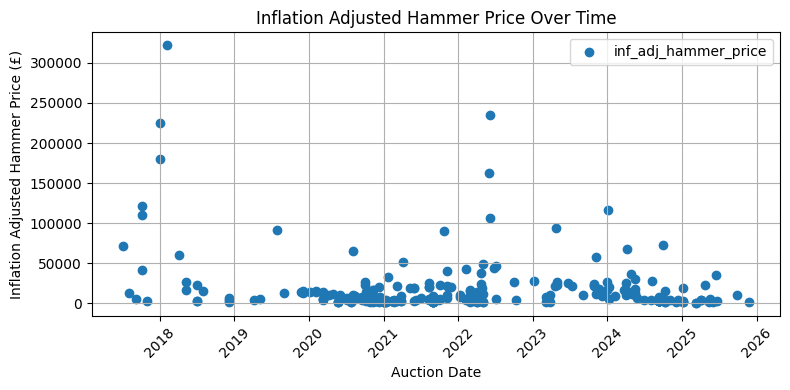

In [5]:
plt.figure(figsize=(8, 4))
plt.scatter(df['auction_date'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

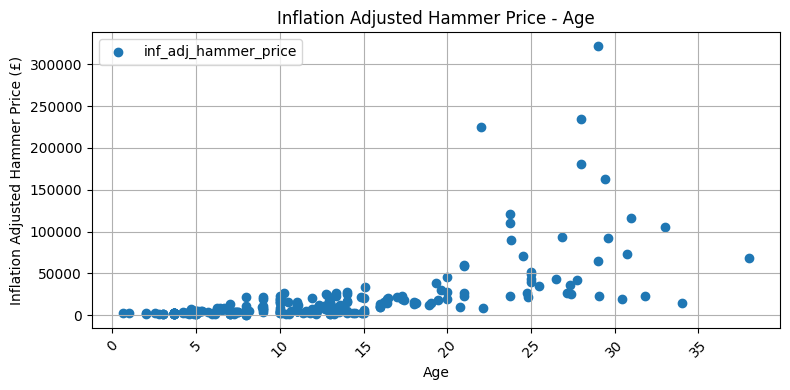

In [6]:
plt.figure(figsize=(8, 4))
plt.scatter(df['age'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Age')
plt.xlabel('Age')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

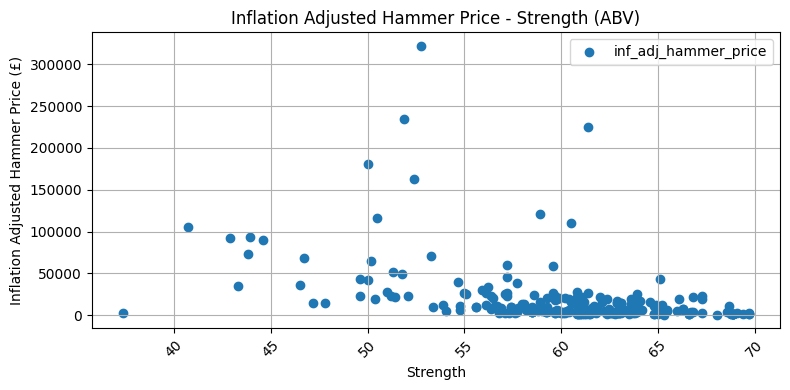

In [7]:
plt.figure(figsize=(8, 4))
plt.scatter(df['strength'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Strength (ABV)')
plt.xlabel('Strength')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Data preparation

In [8]:
df.isnull().sum()

auction_date                                           0
distillery                                             0
region                                                 0
country                                                0
strength                                               0
rla                                                    0
bulk_litres                                            0
distillery_status                                     15
cask_type                                             20
cask_filling                                         125
previous_spirit                                       14
age                                                    0
bottles_at_cask_strength                               0
volume_12m                                             0
volume_6m                                              0
volume_3m                                              0
inf_adj_hammer_price                                   0
inf_adj_hammer_price_per_bottle

In [9]:
# Drop unused columns
df.drop(columns=['inf_adj_hammer_price_per_bottle_at_cask_strength'], inplace=True)

In [10]:
# Drop columns with too much NaN values
df.drop(columns=['cask_filling', 'distillery_status'], inplace=True)
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,cask_type,previous_spirit,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,inf_adj_hammer_price,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_per_age,inf_adj_hammer_price_per_age
0,2025-11-23,Annandale,Lowlands,Scotland,63.5,126.17,198.70,Barrel,Bourbon,4.89,283.860000,78,12,1,1375.00,10.90,2.23,281.19
1,2025-09-28,Bruichladdich,Islay,Scotland,53.4,66.75,125.00,Barrel,Bourbon,20.74,178.570000,112,28,6,10114.50,151.53,7.31,487.68
2,2025-06-22,Ardmore,Highlands,Scotland,57.6,92.62,160.80,Barrel,Bourbon,14.47,229.710000,131,61,22,2309.94,24.94,1.72,159.64
3,2025-06-16,Springbank,Campbeltown,Scotland,43.3,57.90,131.80,Hogshead,Bourbon,25.46,188.285714,131,61,22,35151.19,607.10,23.85,1380.64
4,2025-06-02,Tullibardine,Highlands,Scotland,69.4,109.00,157.06,Barrel,NaN,7.24,224.370000,131,61,22,1531.59,14.05,1.94,211.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2017-10-04,Macallan,Speyside,Scotland,58.9,58.90,141.09,Hogshead,Sherry,23.76,201.560000,7,7,5,121292.71,2059.30,86.67,5104.91
251,2017-10-04,Macallan,Speyside,Scotland,60.5,60.50,186.45,Hogshead,Sherry,23.76,266.360000,7,7,5,109913.15,1816.75,76.46,4625.97
252,2017-09-06,Tullibardine,Highlands,Scotland,59.0,59.00,168.00,Barrel,Bourbon,10.68,240.000000,6,6,5,4958.21,84.04,7.87,464.25
253,2017-08-02,Bruichladdich,Islay,Scotland,53.9,53.90,162.00,Barrel,Bourbon,13.59,231.430000,5,5,5,12498.55,231.88,17.06,919.69


In [11]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

auction_date                                         0
distillery                                           0
region                                               0
country                                              0
strength                                             0
rla                                                  0
bulk_litres                                          0
cask_type                                            0
previous_spirit                                      0
age                                                  0
bottles_at_cask_strength                             0
volume_12m                                           0
volume_6m                                            0
volume_3m                                            0
inf_adj_hammer_price                                 0
inf_adj_hammer_price_per_litre_of_alcohol            0
inf_adj_hammer_price_per_litre_of_alcohol_per_age    0
inf_adj_hammer_price_per_age                         0
dtype: int

In [12]:
df

,auction_date,distillery,region,country,strength,rla,bulk_litres,cask_type,previous_spirit,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,inf_adj_hammer_price,inf_adj_hammer_price_per_litre_of_alcohol,inf_adj_hammer_price_per_litre_of_alcohol_per_age,inf_adj_hammer_price_per_age
0,2025-11-23,Annandale,Lowlands,Scotland,63.5,126.17,198.70,Barrel,Bourbon,4.89,283.860000,78,12,1,1375.00,10.90,2.23,281.19
1,2025-09-28,Bruichladdich,Islay,Scotland,53.4,66.75,125.00,Barrel,Bourbon,20.74,178.570000,112,28,6,10114.50,151.53,7.31,487.68
2,2025-06-22,Ardmore,Highlands,Scotland,57.6,92.62,160.80,Barrel,Bourbon,14.47,229.710000,131,61,22,2309.94,24.94,1.72,159.64
3,2025-06-16,Springbank,Campbeltown,Scotland,43.3,57.90,131.80,Hogshead,Bourbon,25.46,188.285714,131,61,22,35151.19,607.10,23.85,1380.64
4,2025-05-19,Arran,Highlands,Scotland,58.6,134.00,226.00,Hogshead,Sherry,12.21,322.857143,134,66,22,5342.12,39.87,3.27,437.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2017-10-04,Macallan,Speyside,Scotland,58.9,58.90,141.09,Hogshead,Sherry,23.76,201.560000,7,7,5,121292.71,2059.30,86.67,5104.91
217,2017-10-04,Macallan,Speyside,Scotland,60.5,60.50,186.45,Hogshead,Sherry,23.76,266.360000,7,7,5,109913.15,1816.75,76.46,4625.97
218,2017-09-06,Tullibardine,Highlands,Scotland,59.0,59.00,168.00,Barrel,Bourbon,10.68,240.000000,6,6,5,4958.21,84.04,7.87,464.25
219,2017-08-02,Bruichladdich,Islay,Scotland,53.9,53.90,162.00,Barrel,Bourbon,13.59,231.430000,5,5,5,12498.55,231.88,17.06,919.69


In [13]:
df['distillery'] = df['distillery'].str.lower()
df['region'] = df['region'].str.lower()
df['country'] = df['country'].str.lower()
df['cask_type'] = df['cask_type'].str.lower()
df['previous_spirit'] = df['previous_spirit'].str.lower()

### Outliers filtering

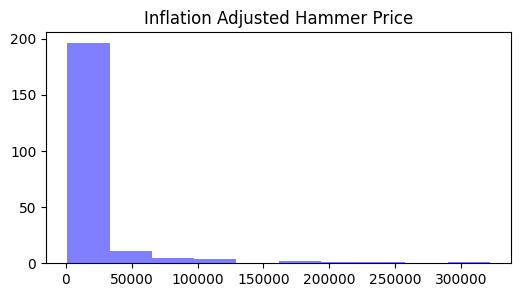

In [14]:
plt.figure(figsize=(6, 3))
plt.hist(df['inf_adj_hammer_price'], color='blue', alpha=0.5)
plt.title('Inflation Adjusted Hammer Price')
plt.show()

In [15]:
Q1 = df['inf_adj_hammer_price'].quantile(0.25)
Q3 = df['inf_adj_hammer_price'].quantile(0.75)
IQR = Q3 - Q1

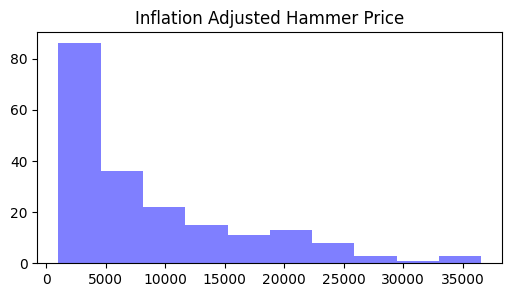

In [16]:

filtro = (df['inf_adj_hammer_price'] >= (Q1 - 1.5 * IQR)) & (df['inf_adj_hammer_price'] <= (Q3 + 1.5 * IQR)) & (df['strength'] >= 40)
df = df[filtro].reset_index(drop=True)
plt.figure(figsize=(6, 3))
plt.hist(df['inf_adj_hammer_price'], color='blue', alpha=0.5)
plt.title('Inflation Adjusted Hammer Price')
plt.show()

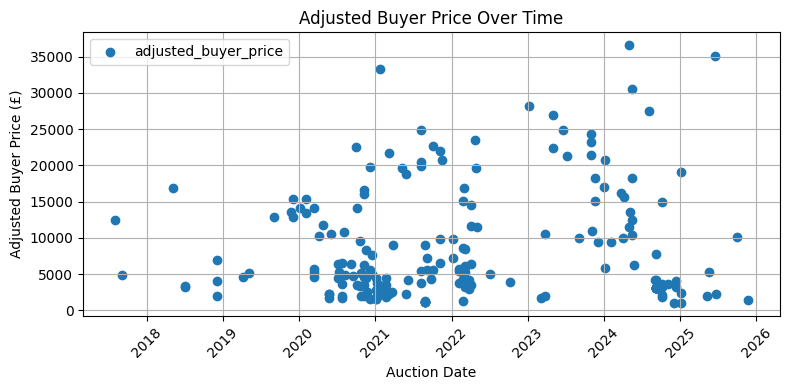

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(df['auction_date'], df['inf_adj_hammer_price'], label='adjusted_buyer_price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

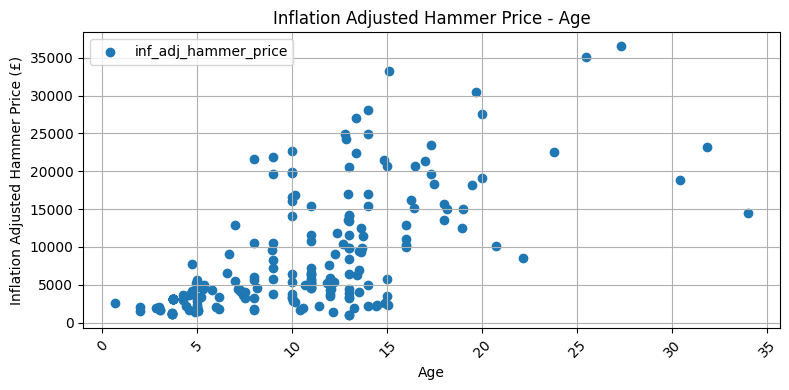

In [18]:
plt.figure(figsize=(8, 4))
plt.scatter(df['age'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Age')
plt.xlabel('Age')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

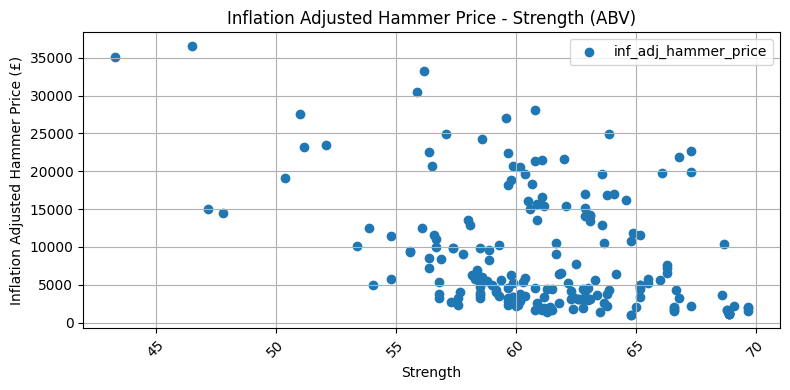

In [19]:
plt.figure(figsize=(8, 4))
plt.scatter(df['strength'], df['inf_adj_hammer_price'], label='inf_adj_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price - Strength (ABV)')
plt.xlabel('Strength')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
df.drop(columns=['auction_date'], inplace=True)

### Log transformation

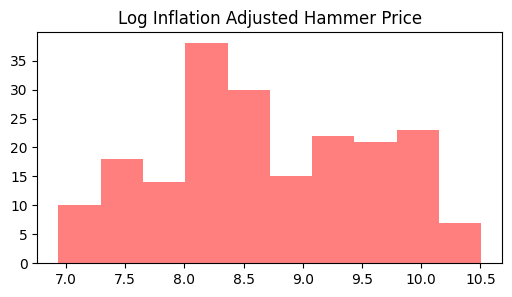

In [21]:
plt.figure(figsize=(6, 3))
plt.hist(np.log(df['inf_adj_hammer_price']), color='red', alpha=0.5)
plt.title('Log Inflation Adjusted Hammer Price')
plt.show()

### Box-Cox transformation

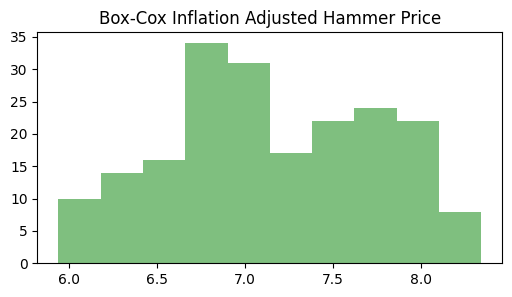

In [22]:
# Supondo que seus dados estejam em y
y_boxcox, fitted_lambda = boxcox(df['inf_adj_hammer_price'])

plt.figure(figsize=(6, 3))
plt.hist(y_boxcox, color='green', alpha=0.5)
plt.title('Box-Cox Inflation Adjusted Hammer Price')
plt.show()

# Feature selection

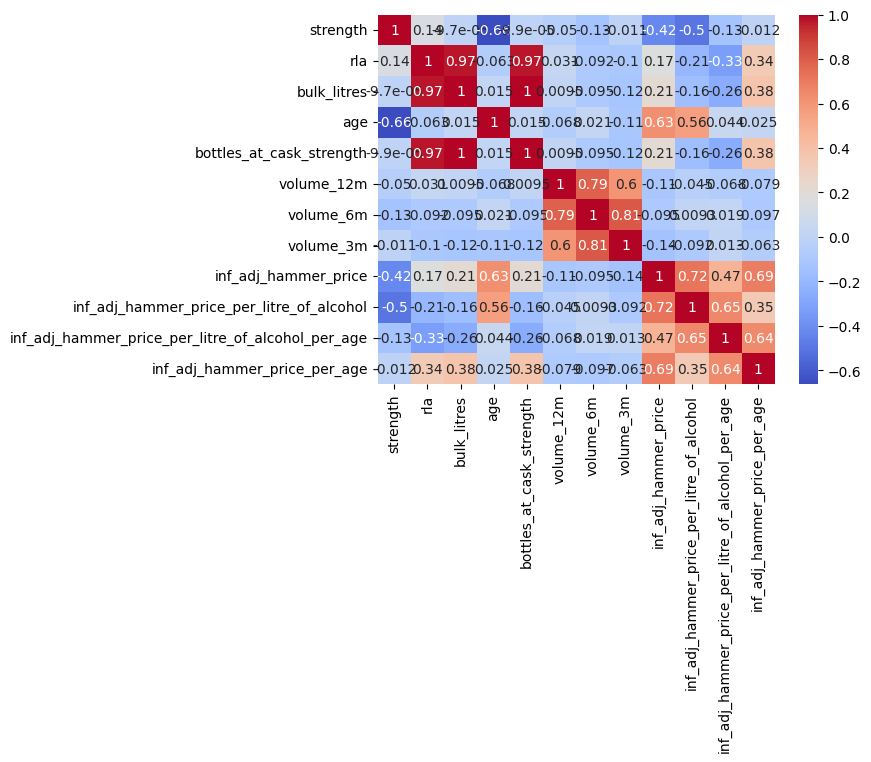

In [23]:
corr = df.drop(['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], axis=1).corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [24]:
# Drop column with high correlation to 'Rla'
df_correlation_selection = df.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

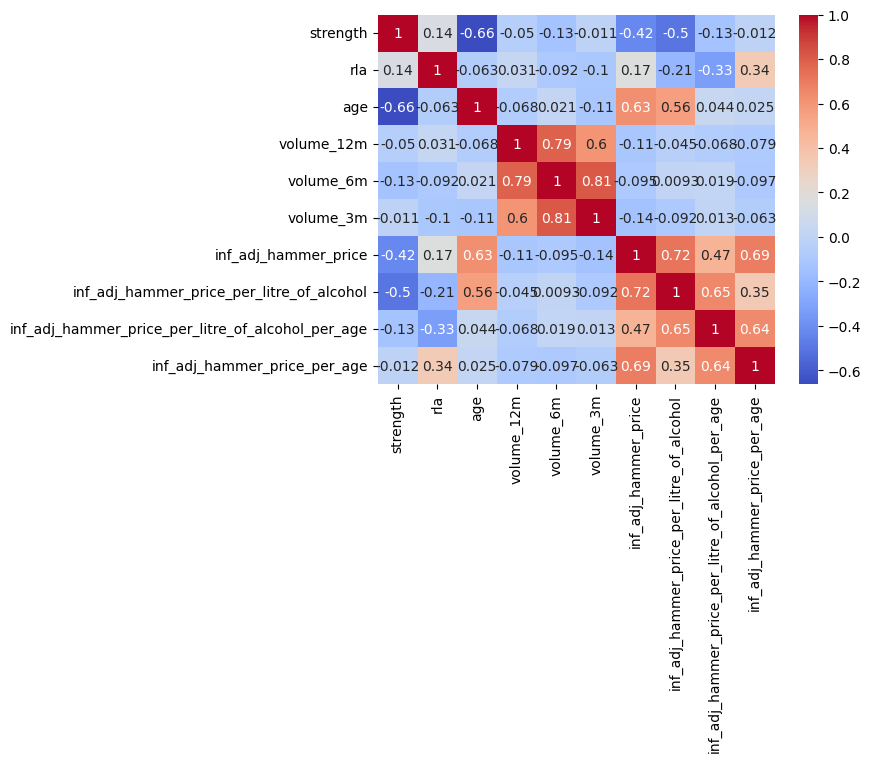

In [25]:
corr = df_correlation_selection.drop(['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], axis=1).corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### One hot encoding for categorical variables

In [26]:
df = pd.get_dummies(df, columns=['distillery', 'region', 'country', 'cask_type', 'previous_spirit'], drop_first=True, dtype=int)

In [27]:
df_correlation_selection = pd.get_dummies(df_correlation_selection,
                                          columns=['distillery', 'region', 'country', 'cask_type', 'previous_spirit'],
                                          drop_first=True, dtype=int)

# Split train and test data

In [28]:
x = df.drop(columns=['inf_adj_hammer_price', 'inf_adj_hammer_price_per_litre_of_alcohol_per_age',
                     'inf_adj_hammer_price_per_age', 'inf_adj_hammer_price_per_litre_of_alcohol'])

all_numeric_columns = ['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength', 'volume_12m', 'volume_6m', 'volume_3m']

In [29]:
x_columns_all_features = x.columns.to_list()

x_columns_corr_sel = x.drop(columns=['bulk_litres', 'bottles_at_cask_strength']).columns.to_list()

In [30]:
y_standard = df['inf_adj_hammer_price']

x_train_standard, x_test_standard, y_train_standard, y_test_standard = train_test_split(x, y_standard, test_size=0.20, random_state=42)

# Log transformation
y_train_log_standard = np.log(y_train_standard)

# Box-Cox transformation
y_train_boxcox_standard, fitted_lambda_standard = boxcox(y_train_standard)

scaler_x_standard = StandardScaler()

x_train_standard_scaled = x_train_standard.copy()
x_train_standard_scaled[all_numeric_columns] = scaler_x_standard.fit_transform(x_train_standard[all_numeric_columns])

x_test_standard_scaled = x_test_standard.copy()
x_test_standard_scaled[all_numeric_columns] = scaler_x_standard.transform(x_test_standard[all_numeric_columns])

x_train_corr_sel_standard_scaled = x_train_standard_scaled[x_columns_corr_sel]
x_test_corr_sel_standard_scaled = x_test_standard_scaled[x_columns_corr_sel]

x_train_corr_sel_standard = x_train_standard[x_columns_corr_sel]
x_test_corr_sel_standard = x_test_standard[x_columns_corr_sel]

In [31]:
y_per_rla = df['inf_adj_hammer_price_per_litre_of_alcohol']

x_train_per_rla, x_test_per_rla, y_train_per_rla, y_test_per_rla = train_test_split(x, y_per_rla, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_rla = np.log(y_train_per_rla)

# Box-Cox transformation
y_train_boxcox_per_rla, fitted_lambda_per_rla = boxcox(y_train_per_rla)

scaler_x_per_rla = StandardScaler()

x_train_per_rla_scaled = x_train_per_rla.copy()
x_train_per_rla_scaled[all_numeric_columns] = scaler_x_per_rla.fit_transform(x_train_per_rla[all_numeric_columns])

x_test_per_rla_scaled = x_test_per_rla.copy()
x_test_per_rla_scaled[all_numeric_columns] = scaler_x_per_rla.transform(x_test_per_rla[all_numeric_columns])

x_train_corr_sel_per_rla_scaled = x_train_per_rla_scaled[x_columns_corr_sel]
x_test_corr_sel_per_rla_scaled = x_test_per_rla_scaled[x_columns_corr_sel]

x_train_corr_sel_per_rla = x_train_per_rla[x_columns_corr_sel]
x_test_corr_sel_per_rla = x_test_per_rla[x_columns_corr_sel]

In [32]:
y_per_rla_per_age = df['inf_adj_hammer_price_per_litre_of_alcohol_per_age']

x_train_per_rla_per_age, x_test_per_rla_per_age, y_train_per_rla_per_age, y_test_per_rla_per_age = train_test_split(x, y_per_rla_per_age, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_rla_per_age = np.log(y_train_per_rla_per_age)

# Box-Cox transformation
y_train_boxcox_per_rla_per_age, fitted_lambda_per_rla_per_age = boxcox(y_train_per_rla_per_age)

scaler_x_per_rla_per_age = StandardScaler()

x_train_per_rla_per_age_scaled = x_train_per_rla_per_age.copy()
x_train_per_rla_per_age_scaled[all_numeric_columns] = scaler_x_per_rla_per_age.fit_transform(x_train_per_rla_per_age[all_numeric_columns])

x_test_per_rla_per_age_scaled = x_test_per_rla_per_age.copy()
x_test_per_rla_per_age_scaled[all_numeric_columns] = scaler_x_per_rla_per_age.transform(x_test_per_rla_per_age[all_numeric_columns])

x_train_corr_sel_per_rla_per_age_scaled = x_train_per_rla_per_age_scaled[x_columns_corr_sel]
x_test_corr_sel_per_rla_per_age_scaled = x_test_per_rla_per_age_scaled[x_columns_corr_sel]

x_train_corr_sel_per_rla_per_age = x_train_per_rla_per_age[x_columns_corr_sel]
x_test_corr_sel_per_rla_per_age = x_test_per_rla_per_age[x_columns_corr_sel]

In [33]:
y_per_age = df['inf_adj_hammer_price_per_age']

x_train_per_age, x_test_per_age, y_train_per_age, y_test_per_age = train_test_split(x, y_per_age, test_size=0.20, random_state=42)

# Log transformation
y_train_log_per_age = np.log(y_train_per_age)

# Box-Cox transformation
y_train_boxcox_per_age, fitted_lambda_per_age = boxcox(y_train_per_age)

scaler_x_per_age = StandardScaler()

x_train_per_age_scaled = x_train_per_age.copy()
x_train_per_age_scaled[all_numeric_columns] = scaler_x_per_age.fit_transform(x_train_per_age[all_numeric_columns])

x_test_per_age_scaled = x_test_per_age.copy()
x_test_per_age_scaled[all_numeric_columns] = scaler_x_per_age.transform(x_test_per_age[all_numeric_columns])

x_train_corr_sel_per_age_scaled = x_train_per_age_scaled[x_columns_corr_sel]
x_test_corr_sel_per_age_scaled = x_test_per_age_scaled[x_columns_corr_sel]

x_train_corr_sel_per_age = x_train_per_age[x_columns_corr_sel]
x_test_corr_sel_per_age = x_test_per_age[x_columns_corr_sel]

In [34]:
dump(fitted_lambda_standard, 'features/fitted_lambda_standard.pkl')
dump(fitted_lambda_per_rla, 'features/fitted_lambda_per_rla.pkl')
dump(fitted_lambda_per_rla_per_age, 'features/fitted_lambda_per_rla_per_age.pkl')
dump(fitted_lambda_per_age, 'features/fitted_lambda_per_age.pkl')

dump(x_columns_corr_sel, 'features/x_columns_corr_sel.pkl')

['features/x_columns_corr_sel.pkl']

In [35]:
set_key('.env', 'fitted_lambda_standard', str(fitted_lambda_standard))
set_key('.env', 'fitted_lambda_per_rla', str(fitted_lambda_per_rla))
set_key('.env', 'fitted_lambda_per_rla_per_age', str(fitted_lambda_per_rla_per_age))
set_key('.env', 'fitted_lambda_per_age', str(fitted_lambda_per_age))

set_key('.env', 'x_columns_corr_sel', ",".join(x_columns_corr_sel))
set_key('.env', 'x_columns_all_features', ",".join(x_columns_all_features))

(True,
 'x_columns_all_features',
 'strength,rla,bulk_litres,age,bottles_at_cask_strength,volume_12m,volume_6m,volume_3m,distillery_ardmore,distillery_arran,distillery_aultmore,distillery_ben nevis,distillery_benriach,distillery_blair athol,distillery_bonnington,distillery_bruichladdich,distillery_bunnahabhain,distillery_caol ila,distillery_copper house,distillery_craigellachie,distillery_dailuaine,distillery_dalmunach,distillery_dingle,distillery_dufftown,distillery_fettercairn,distillery_girvan,distillery_glasgow,distillery_glen elgin,distillery_glen garioch,distillery_glen moray,distillery_glen ord,distillery_glen spey,distillery_glenallachie,distillery_glenburgie,distillery_glenfarclas,distillery_glenglassaugh,distillery_glenlossie,distillery_glenrothes,distillery_glentauchers,distillery_heaven hill,distillery_inchgower,distillery_invergordon,distillery_knockdhu,distillery_lochindaal (bruichladdich),distillery_longmorn,distillery_north british,distillery_port charlotte,distillery_p

In [36]:
dump(scaler_x_standard, 'scalers/scaler_x_standard.pkl')
dump(scaler_x_per_rla, 'scalers/scaler_x_per_rla.pkl')
dump(scaler_x_per_rla_per_age, 'scalers/scaler_x_per_rla_per_age.pkl')
dump(scaler_x_per_age, 'scalers/scaler_x_per_age.pkl')

['scalers/scaler_x_per_age.pkl']

In [37]:
models_metrics = []
trained_models = {}

# Y = Hammer Price

In [1297]:
y = y_standard

x_train = x_train_standard
x_test = x_test_standard

x_train_scaled = x_train_standard_scaled
x_test_scaled = x_test_standard_scaled

y_train = y_train_standard
y_test = y_test_standard

# Log transformation
y_train_log = y_train_log_standard

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_standard
fitted_lambda = fitted_lambda_standard

x_train_corr_sel = x_train_corr_sel_standard
x_test_corr_sel = x_test_corr_sel_standard

x_train_corr_sel_scaled = x_train_corr_sel_standard_scaled
x_test_corr_sel_scaled = x_test_corr_sel_standard_scaled

## ML Models - No transformation

In [1298]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1299]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

In [1300]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.24
r2: 0.33


,Actual,Predicted,Error
0,3868.86,9170.870221,-5302.01
1,2266.25,-1269.517683,3535.77
2,3255.00,10989.765220,-7734.77
3,19802.10,22468.128365,-2666.03
4,9589.83,8480.334956,1109.50
5,2813.02,4892.764113,-2079.74
6,1596.84,630.471752,966.37
7,3118.48,3601.003692,-482.52
8,3118.48,4360.275398,-1241.80
9,1949.93,475.930955,1474.00


### Random Forest

In [1301]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
283 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -4320.16
Best estimator: RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=1)


In [1302]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.38
n_rmse_range: 0.14
r2: 0.77


,Actual,Predicted,Error
0,3868.86,7993.012120,-4124.15
1,2266.25,4690.136728,-2423.89
2,3255.00,8646.168096,-5391.17
3,19802.10,16414.223787,3387.88
4,9589.83,6761.769954,2828.06
5,2813.02,3121.722352,-308.70
6,1596.84,1967.704486,-370.86
7,3118.48,3349.917451,-231.44
8,3118.48,3388.032084,-269.55
9,1949.93,3543.393220,-1593.46


### SVM

In [1303]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best neg_root_mean_squared_error: -7513.73
Best estimator: SVR(C=10, kernel='linear')


In [1304]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.76
n_rmse_range: 0.29
r2: 0.06


,Actual,Predicted,Error
0,3868.86,5897.677758,-2028.82
1,2266.25,4947.669326,-2681.42
2,3255.00,5178.861926,-1923.86
3,19802.10,6024.732589,13777.37
4,9589.83,5947.481416,3642.35
5,2813.02,3084.858066,-271.84
6,1596.84,1709.156394,-112.32
7,3118.48,4859.918930,-1741.44
8,3118.48,4866.621927,-1748.14
9,1949.93,5086.039309,-3136.11


### Gradient Boosting

In [1305]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -4057.31
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=2,
                          random_state=1)


In [1306]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.39
n_rmse_range: 0.15
r2: 0.75


,Actual,Predicted,Error
0,3868.86,9146.101949,-5277.24
1,2266.25,3429.457796,-1163.21
2,3255.00,3209.688945,45.31
3,19802.10,21047.581576,-1245.48
4,9589.83,8111.959681,1477.87
5,2813.02,1951.882889,861.14
6,1596.84,1900.836495,-304.00
7,3118.48,3011.044801,107.44
8,3118.48,3155.118021,-36.64
9,1949.93,2908.928036,-959.00


## ML Models - Log transformation

In [1307]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1308]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_log)

y_pred = model.predict(x_test_scaled)

In [1309]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.61
n_rmse_range: 0.23
r2: 0.40


,Actual,Predicted,Error
0,3868.86,7868.353216,-3999.49
1,2266.25,1781.185683,485.06
2,3255.00,8614.429457,-5359.43
3,19802.10,30369.594064,-10567.49
4,9589.83,8463.670673,1126.16
5,2813.02,2678.956917,134.06
6,1596.84,1540.922716,55.92
7,3118.48,3356.394766,-237.91
8,3118.48,3595.348299,-476.87
9,1949.93,2033.363506,-83.43


### Random Forest

In [1310]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -0.45
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1311]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.46
n_rmse_range: 0.18
r2: 0.65


,Actual,Predicted,Error
0,3868.86,6604.985366,-2736.13
1,2266.25,3530.319123,-1264.07
2,3255.00,5302.384340,-2047.38
3,19802.10,14310.942527,5491.16
4,9589.83,6648.876140,2940.95
5,2813.02,2641.202995,171.82
6,1596.84,1850.477301,-253.64
7,3118.48,3201.980380,-83.50
8,3118.48,3239.039185,-120.56
9,1949.93,2795.601422,-845.67


### SVM

In [1312]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.39
Best estimator: SVR(C=10)


In [1313]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.17
r2: 0.67


,Actual,Predicted,Error
0,3868.86,8281.128027,-4412.27
1,2266.25,2546.887731,-280.64
2,3255.00,4611.710482,-1356.71
3,19802.10,14754.098708,5048.00
4,9589.83,6969.639646,2620.19
5,2813.02,2372.211176,440.81
6,1596.84,1901.068595,-304.23
7,3118.48,3451.167376,-332.69
8,3118.48,3456.859015,-338.38
9,1949.93,2564.330663,-614.40


### Gradient Boosting

In [1314]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -0.45
Best estimator: GradientBoostingRegressor(random_state=1)


In [1315]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.36
n_rmse_range: 0.14
r2: 0.79


,Actual,Predicted,Error
0,3868.86,8471.970524,-4603.11
1,2266.25,2999.676324,-733.43
2,3255.00,3926.631800,-671.63
3,19802.10,19803.686447,-1.59
4,9589.83,7184.977355,2404.85
5,2813.02,2373.448972,439.57
6,1596.84,1821.478290,-224.64
7,3118.48,3232.616107,-114.14
8,3118.48,3232.616107,-114.14
9,1949.93,2551.368636,-601.44


## ML Models - Box-Cox transformation

In [1316]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1317]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_boxcox)

y_pred = model.predict(x_test_scaled)

In [1318]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.61
n_rmse_range: 0.23
r2: 0.39


,Actual,Predicted,Error
0,3868.86,7794.962195,-3926.10
1,2266.25,1800.615224,465.63
2,3255.00,8497.270428,-5242.27
3,19802.10,31245.399834,-11443.30
4,9589.83,8464.760539,1125.07
5,2813.02,2641.606197,171.41
6,1596.84,1547.106097,49.73
7,3118.48,3353.412166,-234.93
8,3118.48,3586.486214,-468.01
9,1949.93,2047.172653,-97.24


### Random Forest

In [1319]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
239 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.34
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1320]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.44
n_rmse_range: 0.17
r2: 0.68


,Actual,Predicted,Error
0,3868.86,6758.146671,-2889.29
1,2266.25,3200.262031,-934.01
2,3255.00,5094.486060,-1839.49
3,19802.10,15291.302140,4510.80
4,9589.83,6930.169437,2659.66
5,2813.02,2715.311922,97.71
6,1596.84,1809.319903,-212.48
7,3118.48,3209.349751,-90.87
8,3118.48,3235.222780,-116.74
9,1949.93,2753.596374,-803.67


### SVM

In [1321]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.29
Best estimator: SVR(C=10)


In [1322]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.17
r2: 0.67


,Actual,Predicted,Error
0,3868.86,8482.017536,-4613.16
1,2266.25,2636.966723,-370.72
2,3255.00,4506.482378,-1251.48
3,19802.10,15184.823671,4617.28
4,9589.83,6743.917696,2845.91
5,2813.02,2293.973885,519.05
6,1596.84,1956.044976,-359.20
7,3118.48,3569.270931,-450.79
8,3118.48,3576.510584,-458.03
9,1949.93,2808.091509,-858.16


### Gradient Boosting

In [1323]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.34
Best estimator: GradientBoostingRegressor(learning_rate=0.05, min_samples_split=10,
                          n_estimators=200, random_state=1)


In [1324]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.36
n_rmse_range: 0.13
r2: 0.79


,Actual,Predicted,Error
0,3868.86,8532.318093,-4663.46
1,2266.25,2936.520889,-670.27
2,3255.00,4122.074508,-867.07
3,19802.10,19966.507742,-164.41
4,9589.83,7116.877496,2472.95
5,2813.02,2729.925909,83.09
6,1596.84,1830.646694,-233.81
7,3118.48,3233.686105,-115.21
8,3118.48,3233.686105,-115.21
9,1949.93,2335.584364,-385.65


## ML Models - No transformation - Correlation Selection

In [1325]:
features = 'Correlation selected features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1326]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1327]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.24
r2: 0.34


,Actual,Predicted,Error
0,3868.86,9034.638904,-5165.78
1,2266.25,-498.315876,2764.57
2,3255.00,10744.012795,-7489.01
3,19802.10,21644.855216,-1842.76
4,9589.83,8452.745560,1137.08
5,2813.02,4452.374153,-1639.35
6,1596.84,1657.640613,-60.80
7,3118.48,3199.871093,-81.39
8,3118.48,3209.420647,-90.94
9,1949.93,-255.590400,2205.52


### Random Forest

In [1328]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
197 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -4271.62
Best estimator: RandomForestRegressor(max_features='log2', n_estimators=200, random_state=1)


In [1329]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.36
n_rmse_range: 0.14
r2: 0.78


,Actual,Predicted,Error
0,3868.86,8630.666850,-4761.81
1,2266.25,4251.343200,-1985.09
2,3255.00,7636.641350,-4381.64
3,19802.10,17145.412900,2656.69
4,9589.83,7222.150150,2367.68
5,2813.02,3117.363120,-304.34
6,1596.84,2105.874500,-509.03
7,3118.48,3134.072350,-15.59
8,3118.48,3134.072350,-15.59
9,1949.93,3704.427050,-1754.50


### SVM

In [1330]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best neg_root_mean_squared_error: -7624.12
Best estimator: SVR(C=10, kernel='linear')


In [1331]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.76
n_rmse_range: 0.29
r2: 0.06


,Actual,Predicted,Error
0,3868.86,6262.094641,-2393.23
1,2266.25,4618.250608,-2352.00
2,3255.00,4424.380197,-1169.38
3,19802.10,5377.259687,14424.84
4,9589.83,5825.044329,3764.79
5,2813.02,3727.502528,-914.48
6,1596.84,2264.907384,-668.07
7,3118.48,4203.807639,-1085.33
8,3118.48,4206.115746,-1087.64
9,1949.93,5490.098432,-3540.17


### Gradient Boosting

In [1332]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best neg_root_mean_squared_error: -4031.22
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_split=10,
                          random_state=1)


In [1333]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.36
n_rmse_range: 0.14
r2: 0.79


,Actual,Predicted,Error
0,3868.86,10325.201294,-6456.34
1,2266.25,4481.408636,-2215.16
2,3255.00,4146.067777,-891.07
3,19802.10,20394.299866,-592.20
4,9589.83,8272.985550,1316.84
5,2813.02,2067.118138,745.90
6,1596.84,2116.466330,-519.63
7,3118.48,3126.133647,-7.65
8,3118.48,3126.133647,-7.65
9,1949.93,4114.490518,-2164.56


## ML Models - Log transformation - Correlation Selection

In [1334]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1335]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train_log)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1336]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.58
n_rmse_range: 0.22
r2: 0.45


,Actual,Predicted,Error
0,3868.86,7725.147108,-3856.29
1,2266.25,1842.471809,423.78
2,3255.00,8303.682039,-5048.68
3,19802.10,28446.265573,-8644.17
4,9589.83,8468.722381,1121.11
5,2813.02,2547.054111,265.97
6,1596.84,1674.140534,-77.30
7,3118.48,3249.055728,-130.58
8,3118.48,3252.918564,-134.44
9,1949.93,1915.423362,34.51


### Random Forest

In [1337]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -0.45
Best estimator: RandomForestRegressor(max_features='log2', random_state=1)


In [1338]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.43
n_rmse_range: 0.16
r2: 0.70


,Actual,Predicted,Error
0,3868.86,7585.186320,-3716.33
1,2266.25,2707.732686,-441.48
2,3255.00,5291.591218,-2036.59
3,19802.10,17626.208375,2175.89
4,9589.83,6850.712047,2739.12
5,2813.02,2732.756221,80.26
6,1596.84,1900.425930,-303.59
7,3118.48,3145.510323,-27.03
8,3118.48,3145.510323,-27.03
9,1949.93,3122.531096,-1172.60


### SVM

In [1339]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.39
Best estimator: SVR(C=10)


In [1340]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.17
r2: 0.68


,Actual,Predicted,Error
0,3868.86,8034.167423,-4165.31
1,2266.25,2574.069941,-307.82
2,3255.00,4682.859780,-1427.86
3,19802.10,14430.102646,5372.00
4,9589.83,6819.185484,2770.64
5,2813.02,2355.501186,457.52
6,1596.84,1905.642287,-308.80
7,3118.48,3442.089707,-323.61
8,3118.48,3450.679318,-332.20
9,1949.93,2533.016647,-583.09


### Gradient Boosting

In [1341]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best neg_root_mean_squared_error: -0.43
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_split=10,
                          random_state=1)


In [1342]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.39
n_rmse_range: 0.15
r2: 0.75


,Actual,Predicted,Error
0,3868.86,10085.504108,-6216.64
1,2266.25,2935.148870,-668.90
2,3255.00,4519.681478,-1264.68
3,19802.10,21632.558694,-1830.46
4,9589.83,7871.872872,1717.96
5,2813.02,1981.989934,831.03
6,1596.84,2001.690320,-404.85
7,3118.48,3160.105148,-41.63
8,3118.48,3160.105148,-41.63
9,1949.93,2817.092380,-867.16


## ML Models - Box-Cox transformation - Correlation Selection

In [1343]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

### Linear Regression

In [1344]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1345]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.59
n_rmse_range: 0.22
r2: 0.44


,Actual,Predicted,Error
0,3868.86,7651.551333,-3782.69
1,2266.25,1858.414531,407.84
2,3255.00,8186.227082,-4931.23
3,19802.10,29175.316883,-9373.22
4,9589.83,8470.424194,1119.41
5,2813.02,2515.125822,297.89
6,1596.84,1673.842316,-77.00
7,3118.48,3249.027841,-130.55
8,3118.48,3252.814902,-134.33
9,1949.93,1933.434171,16.50


### Random Forest

In [1346]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
295 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best neg_root_mean_squared_error: -0.33
Best estimator: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=5,
                      n_estimators=50, random_state=1)


In [1347]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.46
n_rmse_range: 0.17
r2: 0.66


,Actual,Predicted,Error
0,3868.86,6875.183186,-3006.32
1,2266.25,2766.009314,-499.76
2,3255.00,5196.735736,-1941.74
3,19802.10,17143.041271,2659.06
4,9589.83,5902.751456,3687.08
5,2813.02,2731.168193,81.85
6,1596.84,1895.740704,-298.90
7,3118.48,3360.285499,-241.81
8,3118.48,3360.285499,-241.81
9,1949.93,2909.424025,-959.49


### SVM

In [1348]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.29
Best estimator: SVR(C=10)


In [1349]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.45
n_rmse_range: 0.17
r2: 0.67


,Actual,Predicted,Error
0,3868.86,7917.680129,-4048.82
1,2266.25,2687.459761,-421.21
2,3255.00,4513.840408,-1258.84
3,19802.10,14392.387038,5409.71
4,9589.83,6569.630394,3020.20
5,2813.02,2324.788823,488.23
6,1596.84,1971.343643,-374.50
7,3118.48,3566.725088,-448.25
8,3118.48,3576.719562,-458.24
9,1949.93,2752.046616,-802.12


### Gradient Boosting

In [1350]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.32
Best estimator: GradientBoostingRegressor(min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1351]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.34
n_rmse_range: 0.13
r2: 0.82


,Actual,Predicted,Error
0,3868.86,10204.906495,-6336.05
1,2266.25,2585.724903,-319.47
2,3255.00,4037.568863,-782.57
3,19802.10,21735.023720,-1932.92
4,9589.83,7851.681999,1738.15
5,2813.02,1838.603518,974.42
6,1596.84,1967.968522,-371.13
7,3118.48,3169.068593,-50.59
8,3118.48,3169.068593,-50.59
9,1949.93,2709.969781,-760.04


# Y = HP per litre of alcohol

In [1352]:
y = y_per_rla

x_train = x_train_per_rla
x_test = x_test_per_rla

x_train_scaled = x_train_per_rla_scaled
x_test_scaled = x_test_per_rla_scaled

y_train = y_train_per_rla
y_test = y_test_per_rla

# Log transformation
y_train_log = y_train_log_per_rla

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla
fitted_lambda = fitted_lambda_per_rla

x_train_corr_sel = x_train_corr_sel_per_rla
x_test_corr_sel = x_test_corr_sel_per_rla

x_train_corr_sel_scaled = x_train_corr_sel_per_rla_scaled
x_test_corr_sel_scaled = x_test_corr_sel_per_rla_scaled

## ML Models - No transformation - HP per Litre of Alcohol

In [1353]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1354]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

In [1355]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.71
n_rmse_range: 0.17
r2: 0.35


,Actual,Predicted,Error
0,63.77,163.497515,-99.73
1,16.73,-71.074439,87.80
2,20.23,-51.005994,71.24
3,133.09,164.166405,-31.08
4,97.46,87.096183,10.36
5,106.11,98.993241,7.12
6,43.56,32.926294,10.63
7,21.27,31.406392,-10.14
8,21.22,48.555301,-27.34
9,29.02,67.519549,-38.50


### Random Forest

In [1356]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
233 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -82.39
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [1357]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.39
n_rmse_range: 0.09
r2: 0.80


,Actual,Predicted,Error
0,63.77,125.826900,-62.06
1,16.73,34.488800,-17.76
2,20.23,45.744100,-25.51
3,133.09,118.796700,14.29
4,97.46,78.249400,19.21
5,106.11,108.399725,-2.29
6,43.56,51.815000,-8.25
7,21.27,21.898500,-0.63
8,21.22,22.247400,-1.03
9,29.02,46.453700,-17.43


### SVM

In [1358]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best neg_root_mean_squared_error: -90.10
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1359]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.15
r2: 0.50


,Actual,Predicted,Error
0,63.77,113.525897,-49.76
1,16.73,-24.658728,41.39
2,20.23,26.008076,-5.78
3,133.09,133.935427,-0.85
4,97.46,78.808674,18.65
5,106.11,90.188910,15.92
6,43.56,39.731519,3.83
7,21.27,20.241553,1.03
8,21.22,20.131643,1.09
9,29.02,20.712972,8.31


### Gradient Boosting

In [1360]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best neg_root_mean_squared_error: -84.23
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=2,
                          n_estimators=50, random_state=1)


In [1361]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.48
n_rmse_range: 0.12
r2: 0.70


,Actual,Predicted,Error
0,63.77,130.854052,-67.08
1,16.73,28.024270,-11.29
2,20.23,30.079357,-9.85
3,133.09,126.316764,6.77
4,97.46,81.212186,16.25
5,106.11,111.840090,-5.73
6,43.56,48.796306,-5.24
7,21.27,23.285301,-2.02
8,21.22,23.285301,-2.07
9,29.02,44.347189,-15.33


## ML Models - Log transformation - HP per Litre of Alcohol

In [1362]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1363]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_log)

y_pred = model.predict(x_test_scaled)

In [1364]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.16
r2: 0.46


,Actual,Predicted,Error
0,63.77,128.943866,-65.17
1,16.73,11.669305,5.06
2,20.23,43.055839,-22.83
3,133.09,213.504642,-80.41
4,97.46,86.407137,11.05
5,106.11,83.815130,22.29
6,43.56,43.942929,-0.38
7,21.27,22.886112,-1.62
8,21.22,24.391110,-3.17
9,29.02,29.031697,-0.01


### Random Forest

In [1365]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best neg_root_mean_squared_error: -0.44
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
235 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [1366]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.15
r2: 0.51


,Actual,Predicted,Error
0,63.77,112.106075,-48.34
1,16.73,31.623658,-14.89
2,20.23,38.756130,-18.53
3,133.09,115.063615,18.03
4,97.46,74.963129,22.50
5,106.11,76.546373,29.56
6,43.56,49.949660,-6.39
7,21.27,21.842740,-0.57
8,21.22,21.961558,-0.74
9,29.02,45.328045,-16.31


### SVM

In [1367]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.41
Best estimator: SVR(C=10)


In [1368]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.60
n_rmse_range: 0.15
r2: 0.53


,Actual,Predicted,Error
0,63.77,137.495714,-73.73
1,16.73,19.045577,-2.32
2,20.23,31.914169,-11.68
3,133.09,100.818817,32.27
4,97.46,71.777699,25.68
5,106.11,65.943567,40.17
6,43.56,50.623918,-7.06
7,21.27,23.537810,-2.27
8,21.22,23.521701,-2.30
9,29.02,37.415966,-8.40


### Gradient Boosting

In [1369]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.45
Best estimator: GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200, random_state=1)


In [1370]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.52
n_rmse_range: 0.13
r2: 0.66


,Actual,Predicted,Error
0,63.77,144.787380,-81.02
1,16.73,24.325720,-7.60
2,20.23,24.089001,-3.86
3,133.09,129.604035,3.49
4,97.46,80.821472,16.64
5,106.11,83.743761,22.37
6,43.56,53.142388,-9.58
7,21.27,21.689791,-0.42
8,21.22,22.065206,-0.85
9,29.02,38.473080,-9.45


## ML Models - Box-Cox transformation - HP per Litre of Alcohol

In [1371]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1372]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_boxcox)

y_pred = model.predict(x_test_scaled)

In [1373]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.16
r2: 0.46


,Actual,Predicted,Error
0,63.77,121.741986,-57.97
1,16.73,13.546159,3.18
2,20.23,43.151063,-22.92
3,133.09,238.071067,-104.98
4,97.46,86.566539,10.89
5,106.11,81.923621,24.19
6,43.56,44.240662,-0.68
7,21.27,22.800753,-1.53
8,21.22,23.942711,-2.72
9,29.02,28.159239,0.86


### Random Forest

In [1374]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
184 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.24
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1375]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.62
n_rmse_range: 0.15
r2: 0.50


,Actual,Predicted,Error
0,63.77,113.947180,-50.18
1,16.73,28.253181,-11.52
2,20.23,37.581997,-17.35
3,133.09,104.995077,28.09
4,97.46,77.551746,19.91
5,106.11,77.985759,28.12
6,43.56,51.777824,-8.22
7,21.27,21.803712,-0.53
8,21.22,22.030579,-0.81
9,29.02,37.963664,-8.94


### SVM

In [1376]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.22
Best estimator: SVR(C=10)


In [1377]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.15
r2: 0.48


,Actual,Predicted,Error
0,63.77,126.727280,-62.96
1,16.73,20.341829,-3.61
2,20.23,29.327643,-9.10
3,133.09,99.113979,33.98
4,97.46,65.779184,31.68
5,106.11,71.101417,35.01
6,43.56,54.494322,-10.93
7,21.27,25.038013,-3.77
8,21.22,25.032082,-3.81
9,29.02,42.456679,-13.44


### Gradient Boosting

In [1378]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.24
Best estimator: GradientBoostingRegressor(min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1379]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.58
n_rmse_range: 0.14
r2: 0.56


,Actual,Predicted,Error
0,63.77,160.121163,-96.35
1,16.73,23.420145,-6.69
2,20.23,24.992533,-4.76
3,133.09,144.473077,-11.38
4,97.46,76.423465,21.04
5,106.11,79.751531,26.36
6,43.56,56.051329,-12.49
7,21.27,22.342054,-1.07
8,21.22,22.342054,-1.12
9,29.02,34.751302,-5.73


## ML Models - No transformation - Correlation Selection - HP per Litre of Alcohol

In [1380]:
features = 'Correlation selected features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1381]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1382]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.71
n_rmse_range: 0.17
r2: 0.36


,Actual,Predicted,Error
0,63.77,161.783359,-98.01
1,16.73,-44.138667,60.87
2,20.23,-53.212674,73.44
3,133.09,142.612149,-9.52
4,97.46,85.688722,11.77
5,106.11,91.268894,14.84
6,43.56,59.501898,-15.94
7,21.27,21.057853,0.21
8,21.22,20.544571,0.68
9,29.02,48.765174,-19.75


### Random Forest

In [1383]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
283 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -81.85
Best estimator: RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=1)


In [1384]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.50
n_rmse_range: 0.12
r2: 0.67


,Actual,Predicted,Error
0,63.77,115.191246,-51.42
1,16.73,38.261801,-21.53
2,20.23,49.632885,-29.40
3,133.09,121.977424,11.11
4,97.46,69.402665,28.06
5,106.11,72.436049,33.67
6,43.56,53.658910,-10.10
7,21.27,22.575531,-1.31
8,21.22,22.575531,-1.36
9,29.02,43.973729,-14.95


### SVM

In [1385]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
Best neg_root_mean_squared_error: -89.80
Best estimator: SVR(C=10, epsilon=0.2, kernel='linear')


In [1386]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.61
n_rmse_range: 0.15
r2: 0.51


,Actual,Predicted,Error
0,63.77,113.527059,-49.76
1,16.73,-25.854277,42.58
2,20.23,28.068064,-7.84
3,133.09,134.488648,-1.40
4,97.46,79.124826,18.34
5,106.11,89.209336,16.90
6,43.56,40.913568,2.65
7,21.27,20.541701,0.73
8,21.22,20.427298,0.79
9,29.02,20.315824,8.70


### Gradient Boosting

In [1387]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -84.66
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=10, min_samples_leaf=2,
                          random_state=1)


In [1388]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.68
n_rmse_range: 0.17
r2: 0.40


,Actual,Predicted,Error
0,63.77,153.002519,-89.23
1,16.73,32.546092,-15.82
2,20.23,29.016672,-8.79
3,133.09,143.075004,-9.99
4,97.46,88.214346,9.25
5,106.11,289.803685,-183.69
6,43.56,62.127762,-18.57
7,21.27,20.535537,0.73
8,21.22,20.535537,0.68
9,29.02,64.253096,-35.23


## ML Models - Log transformation - Correlation Selection - HP per Litre of Alcohol

In [1389]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1390]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train_log)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1391]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.15
r2: 0.48


,Actual,Predicted,Error
0,63.77,126.633122,-62.86
1,16.73,12.064719,4.67
2,20.23,41.526386,-21.30
3,133.09,200.183734,-67.09
4,97.46,86.457808,11.00
5,106.11,79.750583,26.36
6,43.56,47.681317,-4.12
7,21.27,22.165242,-0.90
8,21.22,22.101986,-0.88
9,29.02,27.372847,1.65


### Random Forest

In [1392]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
226 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.44
Best estimator: RandomForestRegressor(max_features='log2', n_estimators=200, random_state=1)


In [1393]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.16
r2: 0.47


,Actual,Predicted,Error
0,63.77,114.345215,-50.58
1,16.73,28.886669,-12.16
2,20.23,38.891735,-18.66
3,133.09,101.814077,31.28
4,97.46,70.947639,26.51
5,106.11,75.588683,30.52
6,43.56,51.486426,-7.93
7,21.27,21.430446,-0.16
8,21.22,21.430446,-0.21
9,29.02,43.362008,-14.34


### SVM

In [1394]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.40
Best estimator: SVR(C=10)


In [1395]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.64
n_rmse_range: 0.15
r2: 0.48


,Actual,Predicted,Error
0,63.77,130.775342,-67.01
1,16.73,18.598694,-1.87
2,20.23,30.336941,-10.11
3,133.09,97.954122,35.14
4,97.46,69.916056,27.54
5,106.11,64.283035,41.83
6,43.56,50.656260,-7.10
7,21.27,23.498148,-2.23
8,21.22,23.472157,-2.25
9,29.02,37.357492,-8.34


### Gradient Boosting

In [1396]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.43
Best estimator: GradientBoostingRegressor(min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1397]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.53
n_rmse_range: 0.13
r2: 0.64


,Actual,Predicted,Error
0,63.77,162.477556,-98.71
1,16.73,24.816280,-8.09
2,20.23,25.775900,-5.55
3,133.09,141.649375,-8.56
4,97.46,76.599108,20.86
5,106.11,69.286400,36.82
6,43.56,55.410228,-11.85
7,21.27,22.232640,-0.96
8,21.22,22.232640,-1.01
9,29.02,38.513024,-9.49


## ML Models - Box-Cox transformation - Correlation Selection - HP per Litre of Alcohol

In [1398]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol'

### Linear Regression

In [1399]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1400]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.63
n_rmse_range: 0.15
r2: 0.49


,Actual,Predicted,Error
0,63.77,119.420760,-55.65
1,16.73,13.782864,2.95
2,20.23,41.731174,-21.50
3,133.09,222.577917,-89.49
4,97.46,86.676383,10.78
5,106.11,78.052554,28.06
6,43.56,47.322307,-3.76
7,21.27,22.265047,-1.00
8,21.22,22.214398,-0.99
9,29.02,26.916430,2.10


### Random Forest

In [1401]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.24
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1402]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.16
r2: 0.45


,Actual,Predicted,Error
0,63.77,110.108024,-46.34
1,16.73,28.165638,-11.44
2,20.23,32.530281,-12.30
3,133.09,109.061687,24.03
4,97.46,73.655235,23.80
5,106.11,71.032160,35.08
6,43.56,51.406665,-7.85
7,21.27,21.518183,-0.25
8,21.22,21.518183,-0.30
9,29.02,42.823748,-13.80


### SVM

In [1403]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.22
Best estimator: SVR(C=10)


In [1404]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.16
r2: 0.46


,Actual,Predicted,Error
0,63.77,115.312152,-51.54
1,16.73,20.258531,-3.53
2,20.23,28.627516,-8.40
3,133.09,93.530544,39.56
4,97.46,63.011196,34.45
5,106.11,69.145236,36.96
6,43.56,54.611339,-11.05
7,21.27,25.008394,-3.74
8,21.22,24.993814,-3.77
9,29.02,42.515833,-13.50


### Gradient Boosting

In [1405]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.24
Best estimator: GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=10,
                          n_estimators=200, random_state=1)


In [1406]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.56
n_rmse_range: 0.14
r2: 0.59


,Actual,Predicted,Error
0,63.77,152.377190,-88.61
1,16.73,23.289167,-6.56
2,20.23,31.681665,-11.45
3,133.09,118.387997,14.70
4,97.46,79.231528,18.23
5,106.11,85.207111,20.90
6,43.56,53.836986,-10.28
7,21.27,21.790942,-0.52
8,21.22,21.790942,-0.57
9,29.02,36.949017,-7.93


# Y = HP per litre of alcohol Times Age

In [ ]:
y = y_per_rla_per_age

x_train = x_train_per_rla_per_age
x_test = x_test_per_rla_per_age

x_train_scaled = x_train_per_rla_per_age_scaled
x_test_scaled = x_test_per_rla_per_age_scaled

y_train = y_train_per_rla_per_age
y_test = y_test_per_rla_per_age

# Log transformation
y_train_log = y_train_log_per_rla_per_age

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla_per_age
fitted_lambda = fitted_lambda_per_rla_per_age

x_train_corr_sel = x_train_corr_sel_per_rla_per_age
x_test_corr_sel = x_test_corr_sel_per_rla_per_age

x_train_corr_sel_scaled = x_train_corr_sel_per_rla_per_age_scaled
x_test_corr_sel_scaled = x_test_corr_sel_per_rla_per_age_scaled

## ML Models - No transformation - HP per Litre of Alcohol Times Age

In [1408]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1409]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_test_scaled)

In [1410]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.21
n_rmse_range: 0.13
r2: 0.44


,Actual,Predicted,Error
0,828.995879,2358.501396,-1529.51
1,190.917842,-1208.619866,1399.54
2,161.839652,-2741.584333,2903.42
3,1330.875731,1673.890680,-343.01
4,868.347412,788.503267,79.84
5,530.558280,841.343731,-310.79
6,87.116203,-315.810719,402.93
7,78.493801,284.783244,-206.29
8,78.290864,656.900346,-578.61
9,306.707740,1314.884965,-1008.18


### Random Forest

In [1411]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
151 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best neg_root_mean_squared_error: -1961.56
Best estimator: RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=1)


In [1412]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.89
n_rmse_range: 0.09
r2: 0.70


,Actual,Predicted,Error
0,828.995879,1375.122954,-546.13
1,190.917842,393.266983,-202.35
2,161.839652,580.935540,-419.10
3,1330.875731,1364.276876,-33.40
4,868.347412,803.511153,64.84
5,530.558280,1928.599031,-1398.04
6,87.116203,205.965275,-118.85
7,78.493801,120.040978,-41.55
8,78.290864,123.134075,-44.84
9,306.707740,514.539563,-207.83


### SVM

In [1413]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best neg_root_mean_squared_error: -2590.43
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1414]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.32
n_rmse_range: 0.14
r2: 0.33


,Actual,Predicted,Error
0,828.995879,1327.029559,-498.03
1,190.917842,478.708764,-287.79
2,161.839652,330.841336,-169.00
3,1330.875731,1013.114893,317.76
4,868.347412,825.800859,42.55
5,530.558280,556.769128,-26.21
6,87.116203,-73.073551,160.19
7,78.493801,71.874124,6.62
8,78.290864,71.160140,7.13
9,306.707740,796.343607,-489.64


### Gradient Boosting

In [1415]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best neg_root_mean_squared_error: -2151.00
Best estimator: GradientBoostingRegressor(min_samples_leaf=2, n_estimators=50, random_state=1)


In [1416]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.03
n_rmse_range: 0.11
r2: 0.59


,Actual,Predicted,Error
0,828.995879,1088.938370,-259.94
1,190.917842,540.754478,-349.84
2,161.839652,109.202793,52.64
3,1330.875731,1196.097736,134.78
4,868.347412,753.927635,114.42
5,530.558280,4131.583783,-3601.03
6,87.116203,320.936676,-233.82
7,78.493801,232.285062,-153.79
8,78.290864,232.285062,-153.99
9,306.707740,581.861054,-275.15


## ML Models - Log transformation - HP per Litre of Alcohol Times Age

In [1417]:
features = 'All features'
transformation =  'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1418]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_log)

y_pred = model.predict(x_test_scaled)

In [1419]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.63
n_rmse_range: 0.07
r2: 0.85


,Actual,Predicted,Error
0,828.995879,1581.513941,-752.52
1,190.917842,116.543968,74.37
2,161.839652,314.399517,-152.56
3,1330.875731,2351.060625,-1020.18
4,868.347412,775.183305,93.16
5,530.558280,370.871875,159.69
6,87.116203,139.677159,-52.56
7,78.493801,87.091939,-8.60
8,78.290864,93.470980,-15.18
9,306.707740,275.787818,30.92


### Random Forest

In [1420]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
149 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.56
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1421]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.33
n_rmse_range: 0.14
r2: 0.32


,Actual,Predicted,Error
0,828.995879,1427.296887,-598.30
1,190.917842,311.779370,-120.86
2,161.839652,340.665711,-178.83
3,1330.875731,1185.340778,145.53
4,868.347412,720.118977,148.23
5,530.558280,538.224438,-7.67
6,87.116203,148.356988,-61.24
7,78.493801,83.831878,-5.34
8,78.290864,86.425974,-8.14
9,306.707740,422.081318,-115.37


### SVM

In [1422]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.48
Best estimator: SVR(C=10)


In [1423]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.20
n_rmse_range: 0.13
r2: 0.44


,Actual,Predicted,Error
0,828.995879,1751.655269,-922.66
1,190.917842,183.614174,7.30
2,161.839652,254.541998,-92.70
3,1330.875731,944.164121,386.71
4,868.347412,636.335318,232.01
5,530.558280,453.070048,77.49
6,87.116203,145.950429,-58.83
7,78.493801,86.861952,-8.37
8,78.290864,86.960239,-8.67
9,306.707740,377.382238,-70.67


### Gradient Boosting

In [1424]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.45
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                          n_estimators=200, random_state=1)


In [1425]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.49
n_rmse_range: 0.05
r2: 0.91


,Actual,Predicted,Error
0,828.995879,1917.528128,-1088.53
1,190.917842,359.654476,-168.74
2,161.839652,250.858312,-89.02
3,1330.875731,1495.845116,-164.97
4,868.347412,744.096646,124.25
5,530.558280,365.411405,165.15
6,87.116203,118.576943,-31.46
7,78.493801,65.580864,12.91
8,78.290864,65.580864,12.71
9,306.707740,365.562345,-58.85


## ML Models - Box-Cox transformation - HP per Litre of Alcohol Times Age

In [1426]:
features = 'All features'
transformation =  'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1427]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_boxcox)

y_pred = model.predict(x_test_scaled)

In [1428]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.63
n_rmse_range: 0.07
r2: 0.85


,Actual,Predicted,Error
0,828.995879,1519.012198,-690.02
1,190.917842,123.535465,67.38
2,161.839652,309.429324,-147.59
3,1330.875731,2501.414750,-1170.54
4,868.347412,776.162006,92.19
5,530.558280,355.659724,174.90
6,87.116203,142.176302,-55.06
7,78.493801,87.083080,-8.59
8,78.290864,92.526772,-14.24
9,306.707740,270.249316,36.46


### Random Forest

In [1429]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.39
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1430]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.34
n_rmse_range: 0.14
r2: 0.31


,Actual,Predicted,Error
0,828.995879,1414.386222,-585.39
1,190.917842,287.583565,-96.67
2,161.839652,348.607120,-186.77
3,1330.875731,1129.107572,201.77
4,868.347412,725.110394,143.24
5,530.558280,534.425836,-3.87
6,87.116203,144.495085,-57.38
7,78.493801,82.480723,-3.99
8,78.290864,85.720308,-7.43
9,306.707740,393.693946,-86.99


### SVM

In [1431]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_scaled, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.34
Best estimator: SVR(C=10)


In [1432]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.25
n_rmse_range: 0.13
r2: 0.40


,Actual,Predicted,Error
0,828.995879,1784.268728,-955.27
1,190.917842,188.458891,2.46
2,161.839652,245.420934,-83.58
3,1330.875731,957.711222,373.16
4,868.347412,606.814705,261.53
5,530.558280,448.926465,81.63
6,87.116203,135.832837,-48.72
7,78.493801,89.066372,-10.57
8,78.290864,89.197118,-10.91
9,306.707740,427.069631,-120.36


### Gradient Boosting

In [1433]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.32
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                          n_estimators=200, random_state=1)


In [1434]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.65
n_rmse_range: 0.07
r2: 0.84


,Actual,Predicted,Error
0,828.995879,2085.713623,-1256.72
1,190.917842,356.548860,-165.63
2,161.839652,206.979892,-45.14
3,1330.875731,1580.308646,-249.43
4,868.347412,744.507805,123.84
5,530.558280,358.651700,171.91
6,87.116203,117.054385,-29.94
7,78.493801,65.996378,12.50
8,78.290864,65.996378,12.29
9,306.707740,354.892105,-48.18


## ML Models - No transformation - Correlation Selection - HP per Litre of Alcohol Times Age

In [1435]:
features = 'Correlation selected features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1436]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1437]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.24
n_rmse_range: 0.13
r2: 0.41


,Actual,Predicted,Error
0,828.995879,2346.168745,-1517.17
1,190.917842,-477.538687,668.46
2,161.839652,-2729.849396,2891.69
3,1330.875731,1169.750654,161.13
4,868.347412,745.316857,123.03
5,530.558280,717.702929,-187.14
6,87.116203,301.026920,-213.91
7,78.493801,45.039081,33.45
8,78.290864,33.515746,44.78
9,306.707740,882.192008,-575.48


### Random Forest

In [1438]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best neg_root_mean_squared_error: -1821.06
Best estimator: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      random_state=1)


c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
241 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

In [1439]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.99
n_rmse_range: 0.11
r2: 0.62


,Actual,Predicted,Error
0,828.995879,1538.029449,-709.03
1,190.917842,402.038995,-211.12
2,161.839652,817.364872,-655.53
3,1330.875731,2114.273871,-783.40
4,868.347412,578.524048,289.82
5,530.558280,831.648559,-301.09
6,87.116203,189.367018,-102.25
7,78.493801,108.302428,-29.81
8,78.290864,108.302428,-30.01
9,306.707740,569.264447,-262.56


### SVM

In [1440]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best neg_root_mean_squared_error: -2593.25
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [1441]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.32
n_rmse_range: 0.14
r2: 0.33


,Actual,Predicted,Error
0,828.995879,1317.447644,-488.45
1,190.917842,483.959736,-293.04
2,161.839652,338.128574,-176.29
3,1330.875731,1022.930078,307.95
4,868.347412,826.726454,41.62
5,530.558280,544.856542,-14.30
6,87.116203,-75.032946,162.15
7,78.493801,71.796340,6.70
8,78.290864,71.199490,7.09
9,306.707740,785.912286,-479.20


### Gradient Boosting

In [1442]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -2075.71
Best estimator: GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=10,
                          n_estimators=200, random_state=1)


In [1443]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.22
n_rmse_range: 0.13
r2: 0.43


,Actual,Predicted,Error
0,828.995879,1492.477337,-663.48
1,190.917842,170.041081,20.88
2,161.839652,77.473456,84.37
3,1330.875731,1239.117582,91.76
4,868.347412,788.640617,79.71
5,530.558280,5566.738534,-5036.18
6,87.116203,50.812962,36.30
7,78.493801,92.561909,-14.07
8,78.290864,92.561909,-14.27
9,306.707740,456.485788,-149.78


## ML Models - Log transformation - Correlation Selection - HP per Litre of Alcohol Times Age

In [1444]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1445]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train_log)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1446]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.59
n_rmse_range: 0.06
r2: 0.86


,Actual,Predicted,Error
0,828.995879,1549.050458,-720.05
1,190.917842,120.230131,70.69
2,161.839652,301.514054,-139.67
3,1330.875731,2193.672528,-862.80
4,868.347412,776.042787,92.30
5,530.558280,350.632716,179.93
6,87.116203,152.531363,-65.42
7,78.493801,84.136017,-5.64
8,78.290864,83.946308,-5.66
9,306.707740,258.804599,47.90


### Random Forest

In [1447]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.54
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1448]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.37
n_rmse_range: 0.15
r2: 0.27


,Actual,Predicted,Error
0,828.995879,1527.471506,-698.48
1,190.917842,260.747854,-69.83
2,161.839652,313.884774,-152.05
3,1330.875731,1141.601916,189.27
4,868.347412,718.848342,149.50
5,530.558280,557.962431,-27.40
6,87.116203,151.689261,-64.57
7,78.493801,79.652940,-1.16
8,78.290864,79.652940,-1.36
9,306.707740,403.436905,-96.73


### SVM

In [1449]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.46
Best estimator: SVR(C=10)


In [1450]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.27
n_rmse_range: 0.13
r2: 0.38


,Actual,Predicted,Error
0,828.995879,1607.567783,-778.57
1,190.917842,191.630325,-0.71
2,161.839652,242.031519,-80.19
3,1330.875731,910.450816,420.42
4,868.347412,616.396037,251.95
5,530.558280,391.450520,139.11
6,87.116203,145.032899,-57.92
7,78.493801,86.534084,-8.04
8,78.290864,86.574206,-8.28
9,306.707740,373.246076,-66.54


### Gradient Boosting

In [1451]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.45
Best estimator: GradientBoostingRegressor(min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1452]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.03
n_rmse_range: 0.11
r2: 0.59


,Actual,Predicted,Error
0,828.995879,2178.551366,-1349.56
1,190.917842,344.969423,-154.05
2,161.839652,182.341413,-20.50
3,1330.875731,1410.113198,-79.24
4,868.347412,726.751571,141.60
5,530.558280,454.276396,76.28
6,87.116203,119.573020,-32.46
7,78.493801,78.479084,0.01
8,78.290864,78.479084,-0.19
9,306.707740,432.422628,-125.71


## ML Models - Box-Cox transformation - Correlation Selection - HP per Litre of Alcohol Times Age

In [1453]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

### Linear Regression

In [1454]:
model = LinearRegression()
model.fit(x_train_corr_sel_scaled, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel_scaled)

In [1455]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.63
n_rmse_range: 0.07
r2: 0.85


,Actual,Predicted,Error
0,828.995879,1486.222010,-657.23
1,190.917842,126.200860,64.72
2,161.839652,297.067604,-135.23
3,1330.875731,2334.063263,-1003.19
4,868.347412,777.420581,90.93
5,530.558280,337.111788,193.45
6,87.116203,153.383020,-66.27
7,78.493801,84.600850,-6.11
8,78.290864,84.446079,-6.16
9,306.707740,255.366589,51.34


### Random Forest

In [1456]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
186 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.38
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [1457]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.40
n_rmse_range: 0.15
r2: 0.25


,Actual,Predicted,Error
0,828.995879,1478.831397,-649.84
1,190.917842,269.830368,-78.91
2,161.839652,305.938575,-144.10
3,1330.875731,1179.203864,151.67
4,868.347412,693.470200,174.88
5,530.558280,493.452921,37.11
6,87.116203,142.823744,-55.71
7,78.493801,80.236145,-1.74
8,78.290864,80.236145,-1.95
9,306.707740,423.783511,-117.08


### SVM

In [1458]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel_scaled, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel_scaled)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best neg_root_mean_squared_error: -0.33
Best estimator: SVR(C=10)


In [1459]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.31
n_rmse_range: 0.14
r2: 0.33


,Actual,Predicted,Error
0,828.995879,1538.433736,-709.44
1,190.917842,192.100889,-1.18
2,161.839652,230.135022,-68.30
3,1330.875731,924.868771,406.01
4,868.347412,583.314700,285.03
5,530.558280,382.649635,147.91
6,87.116203,131.820887,-44.70
7,78.493801,88.625261,-10.13
8,78.290864,88.676603,-10.39
9,306.707740,418.539455,-111.83


### Gradient Boosting

In [1460]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.32
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          min_samples_split=10, n_estimators=200,
                          random_state=1)


In [1461]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'n_rmse_mean': n_rmse_mean,
                       'n_rmse_range': n_rmse_range,
                       'y_variable': y_variable,
                       'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 1.02
n_rmse_range: 0.11
r2: 0.60


,Actual,Predicted,Error
0,828.995879,1995.818487,-1166.82
1,190.917842,309.260698,-118.34
2,161.839652,238.597070,-76.76
3,1330.875731,1275.105808,55.77
4,868.347412,728.519598,139.83
5,530.558280,332.401805,198.16
6,87.116203,104.845531,-17.73
7,78.493801,76.094899,2.40
8,78.290864,76.094899,2.20
9,306.707740,389.790168,-83.08


# Metrics

In [1462]:
df_metrics = pd.DataFrame(models_metrics)
df_metrics['n_rmse_mean'] = df_metrics['n_rmse_mean'].round(4)
df_metrics['n_rmse_range'] = df_metrics['n_rmse_range'].round(4)
df_metrics['r2'] = df_metrics['r2'].round(4)
df_metrics

,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2
0,Linear Regression,All features,No transformation,0.6436,0.2434,Inflation Adjusted Hammer Price,0.3281
1,Random Forest,All features,No transformation,0.3806,0.1439,Inflation Adjusted Hammer Price,0.7650
2,SVM,All features,No transformation,0.7607,0.2876,Inflation Adjusted Hammer Price,0.0614
3,Gradient Boost,All features,No transformation,0.3938,0.1489,Inflation Adjusted Hammer Price,0.7485
4,Linear Regression,All features,Log transformation,0.6057,0.2290,Inflation Adjusted Hammer Price,0.4050
...,...,...,...,...,...,...,...
67,Gradient Boost,Correlation selected features,Log transformation,1.0292,0.1095,Inflation Adjusted Hammer Price per Litre of A...,0.5918
68,Linear Regression,Correlation selected features,Box-Cox transformation,0.6263,0.0667,Inflation Adjusted Hammer Price per Litre of A...,0.8488
69,Random Forest,Correlation selected features,Box-Cox transformation,1.3981,0.1488,Inflation Adjusted Hammer Price per Litre of A...,0.2466
70,SVM,Correlation selected features,Box-Cox transformation,1.3144,0.1399,Inflation Adjusted Hammer Price per Litre of A...,0.3342


In [1463]:
df_metrics = df_metrics.loc[df_metrics['r2'] > 0, ]
df_metrics = df_metrics.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_metrics = df_metrics.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_metrics = df_metrics.sort_values('r2', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_r2'})
df_metrics['overall_score'] = df_metrics['ranking_n_rmse_mean'] + df_metrics['ranking_n_rmse_range'] + df_metrics['ranking_r2']
df_metrics = df_metrics.sort_values('overall_score').reset_index(drop=True)
df_metrics

,ranking_r2,ranking_n_rmse_range,ranking_n_rmse_mean,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,overall_score
0,0,0,18,Gradient Boost,All features,Log transformation,0.4894,0.0521,Inflation Adjusted Hammer Price per Litre of A...,0.9077,18
1,7,7,7,Random Forest,All features,No transformation,0.3892,0.0946,Inflation Adjusted Hammer Price per Litre of A...,0.8041,21
2,6,15,0,Gradient Boost,Correlation selected features,Box-Cox transformation,0.3353,0.1268,Inflation Adjusted Hammer Price,0.8177,21
3,1,1,26,Linear Regression,Correlation selected features,Log transformation,0.5947,0.0633,Inflation Adjusted Hammer Price per Litre of A...,0.8637,28
4,8,22,1,Gradient Boost,All features,Box-Cox transformation,0.3568,0.1349,Inflation Adjusted Hammer Price,0.7935,31
...,...,...,...,...,...,...,...,...,...,...,...
67,68,35,70,Random Forest,Correlation selected features,Log transformation,1.3727,0.1461,Inflation Adjusted Hammer Price per Litre of A...,0.2738,173
68,65,69,43,Linear Regression,All features,No transformation,0.6436,0.2434,Inflation Adjusted Hammer Price,0.3281,177
69,69,38,71,Random Forest,Correlation selected features,Box-Cox transformation,1.3981,0.1488,Inflation Adjusted Hammer Price per Litre of A...,0.2466,178
70,70,70,52,SVM,All features,No transformation,0.7607,0.2876,Inflation Adjusted Hammer Price,0.0614,192


In [1464]:
(
    df_metrics
    .groupby('model')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
model,,,
Gradient Boost,0.610522,0.123694,0.676944
Linear Regression,0.698333,0.159917,0.510722
Random Forest,0.737489,0.142806,0.562111
SVM,0.819289,0.165900,0.443389


In [1465]:
(
    df_metrics
    .groupby('features')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
features,,,
All features,0.692914,0.145317,0.567492
Correlation selected features,0.739903,0.150842,0.529092


In [1466]:
(
    df_metrics
    .groupby('transformation')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
transformation,,,
Log transformation,0.686371,0.142792,0.580354
Box-Cox transformation,0.704096,0.145150,0.563667
No transformation,0.758758,0.156296,0.500854


In [1467]:
(
    df_metrics
    .groupby('y_variable')
    .agg(
        n_rmse_mean=('n_rmse_mean', 'mean'),
        n_rmse_range=('n_rmse_range', 'mean'),
        r2=('r2', 'mean')
    )
    .sort_values('n_rmse_mean')
)

,n_rmse_mean,n_rmse_range,r2
y_variable,,,
Inflation Adjusted Hammer Price,0.489033,0.184913,0.586796
Inflation Adjusted Hammer Price per Litre of Alcohol,0.604621,0.146971,0.520396
Inflation Adjusted Hammer Price per Litre of Alcohol Times Age,1.055571,0.112354,0.537683


# Export the best model

In [1201]:
df_top1_model = df_metrics.loc[0, ]
df_top1_model

ranking_r2                                                              0
ranking_n_rmse_range                                                    0
ranking_n_rmse_mean                                                    18
model                                                      Gradient Boost
features                                                     All features
transformation                                         Log transformation
n_rmse_mean                                                        0.4894
n_rmse_range                                                       0.0521
y_variable              Inflation Adjusted Hammer Price per Litre of A...
r2                                                                 0.9077
overall_score                                                          18
Name: 0, dtype: object

In [1208]:
n_rmse_mean = df_top1_model['n_rmse_mean']
n_rmse_range = df_top1_model['n_rmse_range']
r2 = df_top1_model['r2']

top1_model_metrics = f'{n_rmse_mean}_{n_rmse_range}_{r2}'
top1_model_metrics

'0.4894_0.0521_0.9077'

In [1209]:
from dotenv import dotenv_values
from pathlib import Path

env_path = Path(".env")

env_vars = dotenv_values(env_path)

In [1210]:
top1_model = trained_models[top1_model_metrics]

features = df_top1_model['features']
transformation = df_top1_model['transformation']
y_variable = df_top1_model['y_variable']

if features == 'All features':
    features = x_columns_all_features
else:
    features = x_columns_corr_sel

env_vars["MODEL_FEATURES"] = ",".join(features)
env_vars["MODEL_Y_VARIABLE"] = y_variable
env_vars["MODEL_TRANSFORMATION"] = transformation

with env_path.open("w") as f:
    for k, v in env_vars.items():
        f.write(f"{k}={v}\n")

print(f'Features: {features}')
print(f'Transformation: {transformation}')
print(f'Y Variable: {y_variable}')

top1_model

Features: ['strength', 'rla', 'bulk_litres', 'age', 'bottles_at_cask_strength', 'volume_12m', 'volume_6m', 'volume_3m', 'distillery_Ardmore', 'distillery_Arran', 'distillery_Aultmore', 'distillery_Ben Nevis', 'distillery_Benriach', 'distillery_Blair Athol', 'distillery_Bonnington', 'distillery_Bruichladdich', 'distillery_Bunnahabhain', 'distillery_Caol Ila', 'distillery_Copper House', 'distillery_Craigellachie', 'distillery_Dailuaine', 'distillery_Dalmunach', 'distillery_Dingle', 'distillery_Dufftown', 'distillery_Fettercairn', 'distillery_Girvan', 'distillery_Glasgow', 'distillery_Glen Elgin', 'distillery_Glen Garioch', 'distillery_Glen Moray', 'distillery_Glen Ord', 'distillery_Glen Spey', 'distillery_Glenallachie', 'distillery_Glenburgie', 'distillery_Glenfarclas', 'distillery_Glenglassaugh', 'distillery_Glenlossie', 'distillery_Glenrothes', 'distillery_Glentauchers', 'distillery_Heaven Hill', 'distillery_Inchgower', 'distillery_Invergordon', 'distillery_Knockdhu', 'distillery_Lochi

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [1211]:
from joblib import dump
dump(top1_model, "models/top1_model.pkl")

['models/top1_model.pkl']

# Experiments with the top 3 best models (on going)

In [ ]:
df_top3_models = df_metrics.loc[0:2, ]
df_top3_models

In [ ]:
top3_models_experimented = []

## Top 1:
### - Gradient Boost
### - All Features
### - Box-Cox transformation
### - Inflation Adjusted Hammer Price per Litre of Alcohol Times Age

In [ ]:
y = y_per_rla_per_age

x_train = x_train_per_rla_per_age
x_test = x_test_per_rla_per_age

y_train = y_train_per_rla_per_age
y_test = y_test_per_rla_per_age

# Box-Cox transformation
y_train_boxcox = y_train_boxcox_per_rla_per_age
fitted_lambda = fitted_lambda_per_rla_per_age

In [286]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best neg_root_mean_squared_error: -0.32
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                          random_state=1)


In [ ]:
features = 'All features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.92
n_rmse_range: 0.11
r2: 0.60


,Actual,Predicted,Error
0,1363.350478,1054.607778,308.74
1,224.090876,269.722924,-45.63
2,78.493801,79.787635,-1.29
3,364.911131,579.680986,-214.77
4,4668.576149,2080.316228,2588.26
5,12736.846436,4562.133370,8174.71
6,5498.202015,4181.032018,1317.17
7,764.656987,408.229348,356.43
8,1059.146612,887.766525,171.38
9,1308.001063,1450.299482,-142.30


In [288]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df

,feature,importance
0,age,0.796631
1,region_Islay,0.055620
2,strength,0.034116
3,rla,0.020557
4,volume_12m,0.019699
...,...,...
77,region_USA,0.000000
78,country_USA,0.000000
79,previous_spirit_Madeira,0.000000
80,previous_spirit_Port,0.000000


In [289]:
top10_most_important_features = feature_importance_df.loc[0:9, 'feature'].values
top5_most_important_features = feature_importance_df.loc[0:4, 'feature'].values

significant_features = feature_importance_df.loc[feature_importance_df['importance'] > 0, 'feature']

In [ ]:
x_train = x_train_per_rla_per_age[top10_most_important_features]
x_test = x_test_per_rla_per_age[top10_most_important_features]

In [291]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 250}
Best neg_root_mean_squared_error: -0.31
Best estimator: GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5,
                          n_estimators=250, random_state=1)


In [ ]:
features = '10 most important features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.86
n_rmse_range: 0.10
r2: 0.65


,Actual,Predicted,Error
0,1363.350478,1094.651822,268.70
1,224.090876,249.658845,-25.57
2,78.493801,79.001646,-0.51
3,364.911131,399.690059,-34.78
4,4668.576149,2310.026892,2358.55
5,12736.846436,5320.289524,7416.56
6,5498.202015,3408.947715,2089.25
7,764.656987,511.286409,253.37
8,1059.146612,619.865912,439.28
9,1308.001063,1373.586842,-65.59


In [ ]:
x_train = x_train_per_rla_per_age[top5_most_important_features]
x_test = x_test_per_rla_per_age[top5_most_important_features]

In [294]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best neg_root_mean_squared_error: -0.34
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          n_estimators=50, random_state=1)


In [ ]:
features = '5 most important features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.92
n_rmse_range: 0.11
r2: 0.60


,Actual,Predicted,Error
0,1363.350478,1059.204714,304.15
1,224.090876,377.357999,-153.27
2,78.493801,81.378246,-2.88
3,364.911131,776.438897,-411.53
4,4668.576149,2173.994003,2494.58
5,12736.846436,4627.062488,8109.78
6,5498.202015,3994.909023,1503.29
7,764.656987,396.066989,368.59
8,1059.146612,548.078983,511.07
9,1308.001063,1341.823210,-33.82


In [ ]:
x_train = x_train_per_rla_per_age[significant_features]
x_test = x_test_per_rla_per_age[significant_features]

In [297]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 250}
Best neg_root_mean_squared_error: -0.32
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=2,
                          min_samples_split=10, n_estimators=250,
                          random_state=1)


In [ ]:
features = 'Significant features'
transformation = 'Box-Cox transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, inv_boxcox(y_pred, fitted_lambda))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.83
n_rmse_range: 0.10
r2: 0.68


,Actual,Predicted,Error
0,1363.350478,1011.630630,351.72
1,224.090876,331.298713,-107.21
2,78.493801,78.173642,0.32
3,364.911131,533.846725,-168.94
4,4668.576149,2398.178217,2270.40
5,12736.846436,5528.996655,7207.85
6,5498.202015,3880.626919,1617.58
7,764.656987,373.191313,391.47
8,1059.146612,811.908274,247.24
9,1308.001063,1402.123173,-94.12


## Top 2:
### - Gradient Boost
### - Correlation selected features
### - Log transformation
### - Inflation Adjusted Hammer Price

In [299]:
y = y_standard

x_train = x_train_corr_sel_standard
x_test = x_test_corr_sel_standard

y_train = y_train_standard
y_test = y_test_standard

# Log transformation
y_train_log = y_train_log_standard

In [300]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.41
Best estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=2, min_samples_split=15,
                          n_estimators=200, random_state=1)


In [ ]:
features = 'Correlation selected features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.38
n_rmse_range: 0.11
r2: 0.80


,Actual,Predicted,Error
0,9868.56,8215.184714,1653.38
1,2170.00,3038.192507,-868.19
2,3118.48,3184.910495,-66.43
3,3452.34,4090.880253,-638.54
4,33275.23,18275.899857,14999.33
5,18885.38,19642.292639,-756.91
6,23482.50,16394.625688,7087.87
7,10533.15,8882.261471,1650.89
8,11828.57,11528.602017,299.97
9,9489.80,9684.546832,-194.75


In [302]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df

,feature,importance
0,age,0.390613
1,region_Islay,0.229991
2,rla,0.109833
3,region_Lowlands,0.073186
4,volume_12m,0.036236
...,...,...
75,country_USA,0.000000
76,previous_spirit_Port,0.000000
77,previous_spirit_Madeira,0.000000
78,cask_type_Quarter Cask,0.000000


In [303]:
top10_most_important_features = feature_importance_df.loc[0:9, 'feature'].values
top5_most_important_features = feature_importance_df.loc[0:4, 'feature'].values

In [304]:
x_train = x_train_corr_sel_standard[top10_most_important_features]
x_test = x_test_corr_sel_standard[top10_most_important_features]

In [305]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 250}
Best neg_root_mean_squared_error: -0.40
Best estimator: GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2,
                          min_samples_split=15, n_estimators=250,
                          random_state=1)


In [306]:
features = 'Correlation selected features - 10 most important features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.40
n_rmse_range: 0.11
r2: 0.78


,Actual,Predicted,Error
0,9868.56,7609.797038,2258.76
1,2170.00,2864.519222,-694.52
2,3118.48,3175.558788,-57.08
3,3452.34,3003.799813,448.54
4,33275.23,18064.430695,15210.80
5,18885.38,23921.034250,-5035.65
6,23482.50,14160.238548,9322.26
7,10533.15,13434.858001,-2901.71
8,11828.57,6488.020360,5340.55
9,9489.80,9764.356817,-274.56


In [307]:
x_train = x_train_corr_sel_standard[top5_most_important_features]
x_test = x_test_corr_sel_standard[top5_most_important_features]

In [308]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
Best neg_root_mean_squared_error: -0.43
Best estimator: GradientBoostingRegressor(min_samples_split=15, n_estimators=50, random_state=1)


In [309]:
features = 'Correlation selected features - 5 most important features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.46
n_rmse_range: 0.13
r2: 0.71


,Actual,Predicted,Error
0,9868.56,7475.766559,2392.79
1,2170.00,2937.330096,-767.33
2,3118.48,3244.925689,-126.45
3,3452.34,3812.486527,-360.15
4,33275.23,17297.843874,15977.39
5,18885.38,25996.439837,-7111.06
6,23482.50,15126.116324,8356.38
7,10533.15,3580.215028,6952.93
8,11828.57,7315.614430,4512.96
9,9489.80,7487.230422,2002.57


In [310]:
x_train = x_train_corr_sel_standard[significant_features]
x_test = x_test_corr_sel_standard[significant_features]

KeyError: "['bottles_at_cask_strength', 'bulk_litres'] not in index"

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 200}
Best neg_root_mean_squared_error: -0.29
Best estimator: GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=2,
                          min_samples_split=15, n_estimators=200,
                          random_state=1)


In [ ]:
features = 'Correlation selected features - Significant features'
transformation = 'Log transformation'
y_variable = 'Inflation Adjusted Hammer Price'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, np.exp(y_pred))

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

pred_vs_test

n_rmse_mean: 0.41
n_rmse_range: 0.14
r2: 0.74


,Actual,Predicted,Error
0,9868.56,7970.714999,1897.85
1,2170.00,2348.338223,-178.34
2,3118.48,3103.060547,15.42
3,3452.34,3294.508191,157.83
4,12857.14,16372.577987,-3515.44
5,18885.38,18812.361948,73.02
6,23482.50,10863.583185,12618.92
7,10533.15,8919.376229,1613.77
8,4730.98,3845.670385,885.31
9,9489.80,9438.454314,51.35


## Top 3:
### - Gradient Boost
### - All Features
### - No transformation
### - Inflation Adjusted Hammer Price per Litre of Alcohol Times Age

In [ ]:
y = y_per_rla_per_age

x_train = x_train_per_rla_per_age
x_test = x_test_per_rla_per_age

y_train = y_train_per_rla_per_age
y_test = y_test_per_rla_per_age

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 25}
Best neg_root_mean_squared_error: -2229.26
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=6,
                          min_samples_split=15, n_estimators=25,
                          random_state=1)


In [ ]:
features = 'All features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.79
n_rmse_range: 0.09
r2: 0.73


,Actual,Predicted,Error
0,1363.350478,1123.550008,239.80
1,224.090876,549.768167,-325.68
2,78.493801,336.123473,-257.63
3,364.911131,660.461905,-295.55
4,2906.800057,3317.205263,-410.41
5,12736.846436,6790.192343,5946.65
6,5498.202015,3429.254668,2068.95
7,764.656987,1317.128675,-552.47
8,198.584346,541.425851,-342.84
9,1308.001063,1381.197848,-73.20


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_names = x_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df

,feature,importance
0,age,0.557895
1,strength,0.311527
2,region_Islay,0.050473
3,rla,0.048074
4,volume_12m,0.010198
...,...,...
75,cask_type_Quarter Cask,0.000000
76,previous_spirit_Port,0.000000
77,previous_spirit_Rum,0.000000
78,previous_spirit_Virgin Oak,0.000000


In [ ]:
top10_most_important_features = feature_importance_df.loc[0:9, 'feature'].values
top5_most_important_features = feature_importance_df.loc[0:4, 'feature'].values

In [ ]:
x_train = x_train_per_rla_per_age[top10_most_important_features]
x_test = x_test_per_rla_per_age[top10_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 25}
Best neg_root_mean_squared_error: -2228.84
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=6,
                          min_samples_split=15, n_estimators=25,
                          random_state=1)


In [ ]:
features = '10 most important features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.79
n_rmse_range: 0.09
r2: 0.73


,Actual,Predicted,Error
0,1363.350478,1165.333175,198.02
1,224.090876,587.290745,-363.20
2,78.493801,332.295843,-253.80
3,364.911131,661.931886,-297.02
4,2906.800057,3376.243394,-469.44
5,12736.846436,6756.958030,5979.89
6,5498.202015,3384.485076,2113.72
7,764.656987,1321.323385,-556.67
8,198.584346,526.125849,-327.54
9,1308.001063,1436.419888,-128.42


In [ ]:
x_train = x_train_per_rla_per_age[top5_most_important_features]
x_test = x_test_per_rla_per_age[top5_most_important_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 25}
Best neg_root_mean_squared_error: -2228.82
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=6,
                          n_estimators=25, random_state=1)


In [ ]:
features = '5 most important features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.82
n_rmse_range: 0.09
r2: 0.71


,Actual,Predicted,Error
0,1363.350478,1182.158532,181.19
1,224.090876,687.288209,-463.20
2,78.493801,373.087011,-294.59
3,364.911131,899.907818,-535.00
4,2906.800057,3257.289090,-350.49
5,12736.846436,6505.076552,6231.77
6,5498.202015,3375.211012,2122.99
7,764.656987,1289.978851,-525.32
8,198.584346,529.540123,-330.96
9,1308.001063,1331.246568,-23.25


In [ ]:
x_train = x_train_per_rla_per_age[significant_features]
x_test = x_test_per_rla_per_age[significant_features]

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [25, 50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best neg_root_mean_squared_error: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 25}
Best neg_root_mean_squared_error: -2229.23
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=6,
                          min_samples_split=15, n_estimators=25,
                          random_state=1)


In [ ]:
features = 'Significant features'
transformation = 'No transformation'
y_variable = 'Inflation Adjusted Hammer Price per Litre of Alcohol Times Age'

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

print(f"n_rmse_mean: {n_rmse_mean:.2f}")

print(f"n_rmse_range: {n_rmse_range:.2f}")

print(f"r2: {r2:.2f}")

top3_models_experimented.append({'model': 'Gradient Boost',
                                 'features': features,
                                 'transformation': transformation,
                                 'n_rmse_mean': n_rmse_mean,
                                 'n_rmse_range': n_rmse_range,
                                 'y_variable': y_variable,
                                 'r2': r2})

trained_models[f'{round(n_rmse_mean, 4)}_{round(n_rmse_range, 4)}_{round(r2, 4)}'] = best_model

pred_vs_test

pred_vs_test

n_rmse_mean: 0.79
n_rmse_range: 0.09
r2: 0.73


,Actual,Predicted,Error
0,1363.350478,1123.550008,239.80
1,224.090876,549.768167,-325.68
2,78.493801,336.123473,-257.63
3,364.911131,660.461905,-295.55
4,2906.800057,3317.205263,-410.41
5,12736.846436,6790.192343,5946.65
6,5498.202015,3429.254668,2068.95
7,764.656987,1317.128675,-552.47
8,198.584346,547.132270,-348.55
9,1308.001063,1381.197848,-73.20


## Top 3 models experiments metrics

In [1411]:
df_top3_models_experimented = pd.DataFrame(top3_models_experimented)
df_top3_models_experimented['n_rmse_mean'] = df_top3_models_experimented['n_rmse_mean'].round(4)
df_top3_models_experimented['n_rmse_range'] = df_top3_models_experimented['n_rmse_range'].round(4)
df_top3_models_experimented['r2'] = df_top3_models_experimented['r2'].round(4)
df_top3_models_experimented

,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2
0,Gradient Boost,All features,Log transformation,0.4853,0.0555,Inflation Adjusted Hammer Price per Litre of A...,0.8980
1,Gradient Boost,10 most important features,Log transformation,1.7898,0.2046,Inflation Adjusted Hammer Price per Litre of A...,-0.3868
2,Gradient Boost,5 most important features,Log transformation,1.1989,0.1370,Inflation Adjusted Hammer Price per Litre of A...,0.3778
3,Gradient Boost,Significant features,Log transformation,0.4320,0.0494,Inflation Adjusted Hammer Price per Litre of A...,0.9192
4,Gradient Boost,All features,Box-Cox transformation,0.3947,0.1380,Inflation Adjusted Hammer Price,0.7646
5,Gradient Boost,10 most important features,Box-Cox transformation,0.3900,0.1364,Inflation Adjusted Hammer Price,0.7702
6,Gradient Boost,5 most important features,Box-Cox transformation,0.3430,0.1199,Inflation Adjusted Hammer Price,0.8223
7,Gradient Boost,Significant features,Box-Cox transformation,0.4111,0.1438,Inflation Adjusted Hammer Price,0.7446
8,Gradient Boost,All features,No transformation,0.7880,0.0901,Inflation Adjusted Hammer Price per Litre of A...,0.7312
9,Gradient Boost,10 most important features,No transformation,0.7931,0.0906,Inflation Adjusted Hammer Price per Litre of A...,0.7277


In [ ]:
df_top3_models = df_top3_models.drop(columns=['ranking_r2', 'ranking_n_rmse_range', 'ranking_n_rmse_mean', 'overall_score'])

In [ ]:
df_top3_models

,ranking_r2,ranking_n_rmse_range,ranking_n_rmse_mean,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,overall_score
0,0,0,3,Gradient Boost,All features,Log transformation,0.4853,0.0555,Inflation Adjusted Hammer Price per Litre of A...,0.8980,3
1,1,1,4,Gradient Boost,All features,Log transformation,0.4853,0.0555,Inflation Adjusted Hammer Price per Litre of A...,0.8980,6
2,2,6,0,Gradient Boost,Most important features,Box-Cox transformation,0.3900,0.1364,Inflation Adjusted Hammer Price,0.7702,8


In [1419]:
df_top3_models = pd.concat([df_top3_models, df_top3_models_experimented])
df_top3_models

,model,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2
0,Gradient Boost,All features,Log transformation,0.4900,0.055658,Inflation Adjusted Hammer Price per Litre of A...,0.897331
1,Gradient Boost,All features,Box-Cox transformation,0.3400,0.120211,Inflation Adjusted Hammer Price,0.821436
2,Gradient Boost,All features,No transformation,0.5100,0.058472,Inflation Adjusted Hammer Price per Litre of A...,0.886685
0,Gradient Boost,All features,Log transformation,0.4853,0.055500,Inflation Adjusted Hammer Price per Litre of A...,0.898000
1,Gradient Boost,10 most important features,Log transformation,1.7898,0.204600,Inflation Adjusted Hammer Price per Litre of A...,-0.386800
2,Gradient Boost,5 most important features,Log transformation,1.1989,0.137000,Inflation Adjusted Hammer Price per Litre of A...,0.377800
3,Gradient Boost,Significant features,Log transformation,0.4320,0.049400,Inflation Adjusted Hammer Price per Litre of A...,0.919200
4,Gradient Boost,All features,Box-Cox transformation,0.3947,0.138000,Inflation Adjusted Hammer Price,0.764600
5,Gradient Boost,10 most important features,Box-Cox transformation,0.3900,0.136400,Inflation Adjusted Hammer Price,0.770200
6,Gradient Boost,5 most important features,Box-Cox transformation,0.3430,0.119900,Inflation Adjusted Hammer Price,0.822300


In [ ]:
df_top3_models = df_top3_models.loc[df_top3_models['r2'] > 0, ]
df_top3_models = df_top3_models.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_top3_models = df_top3_models.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_top3_models = df_top3_models.sort_values('r2', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_r2'})
df_top3_models['overall_score'] = df_top3_models['ranking_n_rmse_mean'] + df_top3_models['ranking_n_rmse_range'] + df_top3_models['ranking_r2']
df_top3_models = df_top3_models.sort_values('overall_score').reset_index(drop=True)
df_top3_models

# Teste com for

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
models_metrics = []
trained_models = {}

x_features = ['All features', 'Correlation selected features']
x_features_transformation = ['No transformation', 'Log transformation', 'Box-Cox transformation']
y_variables = ['Inflation Adjusted Hammer Price',
               'Inflation Adjusted Hammer Price per Litre of Alcohol',
               'Inflation Adjusted Hammer Price per Age',
               'Inflation Adjusted Hammer Price per Litre of Alcohol per Age']

In [40]:
def set_variables(y_variable, features, transformation):

    fitted_lambda = None
    
    if (y_variable == 'Inflation Adjusted Hammer Price'):
        y = y_standard
        y_test = y_test_standard
    
        if (transformation == 'No transformation'):
            y_train = y_train_standard

        elif (transformation == 'Log transformation'):
            y_train = y_train_log_standard

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_standard
            fitted_lambda = fitted_lambda_standard

        if (features == 'All features'):
            x_train = x_train_standard
            x_test = x_test_standard
            x_train_scaled = x_train_standard_scaled
            x_test_scaled = x_test_standard_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_standard
            x_test = x_test_corr_sel_standard
            x_train_scaled = x_train_corr_sel_standard_scaled
            x_test_scaled = x_test_corr_sel_standard_scaled

    if (y_variable == 'Inflation Adjusted Hammer Price per Litre of Alcohol'):
        y = y_per_rla
        y_test = y_test_per_rla
    
        if (transformation == 'No transformation'):
            y_train = y_train_per_rla
            
        elif (transformation == 'Log transformation'):
            y_train = y_train_log_per_rla

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_per_rla
            fitted_lambda = fitted_lambda_per_rla

        if (features == 'All features'):
            x_train = x_train_per_rla
            x_test = x_test_per_rla
            x_train_scaled = x_train_per_rla_scaled
            x_test_scaled = x_test_per_rla_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_per_rla
            x_test = x_test_corr_sel_per_rla
            x_train_scaled = x_train_corr_sel_per_rla_scaled
            x_test_scaled = x_test_corr_sel_per_rla_scaled

    if (y_variable == 'Inflation Adjusted Hammer Price per Litre of Alcohol per Age'):
        y = y_per_rla_per_age
        y_test = y_test_per_rla_per_age
    
        if (transformation == 'No transformation'):
            y_train = y_train_per_rla_per_age
            
        elif (transformation == 'Log transformation'):
            y_train = y_train_log_per_rla_per_age

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_per_rla_per_age
            fitted_lambda = fitted_lambda_per_rla_per_age

        if (features == 'All features'):
            x_train = x_train_per_rla_per_age
            x_test = x_test_per_rla_per_age
            x_train_scaled = x_train_per_rla_per_age_scaled
            x_test_scaled = x_test_per_rla_per_age_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_per_rla_per_age
            x_test = x_test_corr_sel_per_rla_per_age
            x_train_scaled = x_train_corr_sel_per_rla_per_age_scaled
            x_test_scaled = x_test_corr_sel_per_rla_per_age_scaled

    if (y_variable == 'Inflation Adjusted Hammer Price per Age'):
        y = y_per_age
        y_test = y_test_per_age
    
        if (transformation == 'No transformation'):
            y_train = y_train_per_age
            
        elif (transformation == 'Log transformation'):
            y_train = y_train_log_per_age

        elif (transformation == 'Box-Cox transformation'):
            y_train = y_train_boxcox_per_age
            fitted_lambda = fitted_lambda_per_age

        if (features == 'All features'):
            x_train = x_train_per_age
            x_test = x_test_per_age
            x_train_scaled = x_train_per_age_scaled
            x_test_scaled = x_test_per_age_scaled

        elif (features == 'Correlation selected features'):
            x_train = x_train_corr_sel_per_age
            x_test = x_test_corr_sel_per_age
            x_train_scaled = x_train_corr_sel_per_age_scaled
            x_test_scaled = x_test_corr_sel_per_age_scaled
            
    return y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled

In [41]:
def linear_regression_best_model(x_train_scaled, x_test_scaled, y_train):

    model = LinearRegression()
    model.fit(x_train_scaled, y_train)

    y_pred = model.predict(x_test_scaled)

    return y_pred, model

In [42]:
def random_forest_best_model(x_train, x_test, y_train):

    model = RandomForestRegressor(random_state=1)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test)

    return y_pred, best_model

In [43]:
def svr_best_model(x_train_scaled, x_test_scaled, y_train):

    model = SVR(kernel='linear')

    param_grid = {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf', 'poly']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train_scaled, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test_scaled)

    return y_pred, best_model

In [44]:
def gradient_boost_best_model(x_train, x_test, y_train):

    model = GradientBoostingRegressor(random_state=1)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(x_test)

    return y_pred, best_model

In [ ]:
def model_performance_analysis(model, model_name, y_pred, y_test, fitted_lambda):

    if transformation == 'Box-Cox transformation':
        y_pred = inv_boxcox(y_pred, fitted_lambda)
    elif transformation == 'Log transformation':
        y_pred = np.exp(y_pred)

    pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
    pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

    n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

    n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

    r2 = r2_score(y_test, y_pred)

    models_metrics.append({'model': model_name,
                           'model_object': model,
                           'features': features,
                           'transformation': transformation,
                           'n_rmse_mean': n_rmse_mean,
                           'n_rmse_range': n_rmse_range,
                           'y_variable': y_variable,
                           'r2': r2})

In [46]:
total_tests = len(y_variables) * len(x_features) * len(x_features_transformation) * 4
finished_tests = 0

In [47]:
for y_variable in y_variables:

    for features in x_features:

        for transformation in x_features_transformation:

            y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled = set_variables(y_variable, features, transformation)

            y_pred, best_model = linear_regression_best_model(x_train_scaled, x_test_scaled, y_train)
            model_performance_analysis(best_model, 'Linear Regression', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            y_pred, best_model = random_forest_best_model(x_train, x_test, y_train)
            model_performance_analysis(best_model, 'Random Forest', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            y_pred, best_model = svr_best_model(x_train_scaled, x_test_scaled, y_train)
            model_performance_analysis(best_model, 'Support Vector Regression', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

            y_pred, best_model = gradient_boost_best_model(x_train, x_test, y_train)
            model_performance_analysis(best_model, 'Gradient Boost', y_pred, y_test, fitted_lambda)

            finished_tests += 1
            print("".join(finished_tests * ['|'] + (total_tests - finished_tests) * ['-']) + f' {finished_tests}/{total_tests}\n')

|----------------------------------------------------------------------------------------------- 1/96



||---------------------------------------------------------------------------------------------- 2/96

|||--------------------------------------------------------------------------------------------- 3/96

||||-------------------------------------------------------------------------------------------- 4/96

|||||------------------------------------------------------------------------------------------- 5/96

||||||------------------------------------------------------------------------------------------ 6/96

|||||||----------------------------------------------------------------------------------------- 7/96

||||||||---------------------------------------------------------------------------------------- 8/96

|||||||||--------------------------------------------------------------------------------------- 9/96

||||||||||-------------------------------------------------------------------------------------- 10/96

|||||||||||-------------------------------------------------------------

In [48]:
df_metrics = pd.DataFrame(models_metrics)
df_metrics['n_rmse_mean'] = df_metrics['n_rmse_mean'].round(4)
df_metrics['n_rmse_range'] = df_metrics['n_rmse_range'].round(4)
df_metrics['r2'] = df_metrics['r2'].round(4)

In [49]:
df_metrics = df_metrics.loc[df_metrics['r2'] > 0, ]
df_metrics = df_metrics.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_metrics = df_metrics.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_metrics['overall_score'] = df_metrics['ranking_n_rmse_mean'] + df_metrics['ranking_n_rmse_range']
df_metrics = df_metrics.sort_values('overall_score').reset_index(drop=True).reset_index().rename(columns={'index': 'overall_ranking'})
df_metrics

,overall_ranking,ranking_n_rmse_range,ranking_n_rmse_mean,model,model_object,features,transformation,n_rmse_mean,n_rmse_range,y_variable,r2,overall_score
0,0,4,0,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,No transformation,0.2897,0.1259,Inflation Adjusted Hammer Price per Age,0.7614,4
1,1,5,1,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,Box-Cox transformation,0.2909,0.1265,Inflation Adjusted Hammer Price per Age,0.7594,6
2,2,8,2,Random Forest,"(DecisionTreeRegressor(max_features='sqrt', ra...",Correlation selected features,No transformation,0.3074,0.1336,Inflation Adjusted Hammer Price per Age,0.7313,10
3,3,9,3,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,All features,Box-Cox transformation,0.3095,0.1345,Inflation Adjusted Hammer Price per Age,0.7277,12
4,4,6,12,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Correlation selected features,Box-Cox transformation,0.3369,0.1274,Inflation Adjusted Hammer Price,0.8158,18
...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,89,75,Linear Regression,LinearRegression(),All features,Box-Cox transformation,0.6123,0.2315,Inflation Adjusted Hammer Price,0.3919,164
92,92,90,84,Linear Regression,LinearRegression(),Correlation selected features,No transformation,0.6377,0.2411,Inflation Adjusted Hammer Price,0.3404,174
93,93,91,86,Linear Regression,LinearRegression(),All features,No transformation,0.6436,0.2434,Inflation Adjusted Hammer Price,0.3281,177
94,94,94,94,Support Vector Regression,"SVR(C=10, kernel='linear')",All features,No transformation,0.7607,0.2876,Inflation Adjusted Hammer Price,0.0614,188


# 3 best models ensemble

In [53]:

y_pred_ensemble = 0

top3_models_info = df_metrics.head(3)

for i in range(3):

    model_info = top3_models_info.iloc[i]
    y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled = set_variables(model_info['y_variable'], model_info['features'], model_info['transformation'])

    if model_info['model'] in ['Linear Regression', 'Support Vector Regression']:
        X = x_test_scaled
    else:
        X = x_test

    y_pred = model_info['model_object'].predict(X)

    if model_info['transformation'] == 'Box-Cox transformation':
        y_pred = inv_boxcox(y_pred, fitted_lambda)
    elif model_info['transformation'] == 'Log transformation':
        y_pred = np.exp(y_pred)

    if model_info['y_variable'] == 'Inflation Adjusted Hammer Price per Litre of Alcohol':
        y_pred = y_pred * x_test['rla'].values
    elif model_info['y_variable'] == 'Inflation Adjusted Hammer Price per Litre of Alcohol per Age':
        y_pred = y_pred * x_test['rla'].values * x_test['age'].values
    elif model_info['y_variable'] == 'Inflation Adjusted Hammer Price per Age':
        y_pred = y_pred * x_test['age'].values

    y_pred_ensemble += y_pred

y, y_train, y_test, fitted_lambda, x_train, x_test, x_train_scaled, x_test_scaled = set_variables('Inflation Adjusted Hammer Price', 'All features', 'No transformation')

y_pred_ensemble = y_pred_ensemble / 3

pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_ensemble})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

n_rmse_mean = np.sqrt(np.mean(pred_vs_test['Error']**2)) / y_test.mean()

n_rmse_range = np.sqrt(np.mean(pred_vs_test['Error']**2)) / (y_test.max() - y_test.min())

r2 = r2_score(y_test, y_pred)

df_ensemble_model = pd.DataFrame([{'model': 'Ensemble Model',
                                    ''
                                    'n_rmse_mean':  round(n_rmse_mean, 2),
                                    'n_rmse_range': round(n_rmse_range, 2),
                                    'r2': round(r2, 2)}])

top3_models_info = top3_models_info[['model', 'model_object', 'y_variable', 'features', 'transformation', 'n_rmse_mean', 'n_rmse_range', 'r2', 'overall_ranking']]

df_ensemble_model_top3_models = pd.concat([top3_models_info, df_ensemble_model], ignore_index=True)

df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('n_rmse_mean').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_mean'})
df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('n_rmse_range').reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_n_rmse_range'})
df_ensemble_model_top3_models['overall_score'] = df_ensemble_model_top3_models['ranking_n_rmse_mean'] + df_ensemble_model_top3_models['ranking_n_rmse_range']
df_ensemble_model_top3_models = df_ensemble_model_top3_models.sort_values('overall_score').reset_index(drop=True)

df_ensemble_model_top3_models

,ranking_n_rmse_range,ranking_n_rmse_mean,model,model_object,y_variable,features,transformation,n_rmse_mean,n_rmse_range,r2,overall_ranking,overall_score
0,0,0,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Inflation Adjusted Hammer Price per Age,Correlation selected features,No transformation,0.2897,0.1259,0.7614,0.0,0
1,1,1,Gradient Boost,([DecisionTreeRegressor(criterion='friedman_ms...,Inflation Adjusted Hammer Price per Age,Correlation selected features,Box-Cox transformation,0.2909,0.1265,0.7594,1.0,2
2,2,3,Ensemble Model,NaN,NaN,NaN,NaN,0.3500,0.1300,0.7600,NaN,5
3,3,2,Random Forest,"(DecisionTreeRegressor(max_features='sqrt', ra...",Inflation Adjusted Hammer Price per Age,Correlation selected features,No transformation,0.3074,0.1336,0.7313,2.0,5


In [54]:
df_ensemble_model_top3_models.to_csv('models_metrics/models_metrics.csv', index=False)

In [55]:
for i in range(3):
    print(top3_models_info.iloc[i]['model'])
    print(f"models/top{i+1}_model.pkl")
    model = top3_models_info.iloc[i]['model_object']
    dump(model, f"models/top{i+1}_model.pkl")

Gradient Boost
models/top1_model.pkl
Gradient Boost
models/top2_model.pkl
Random Forest
models/top3_model.pkl
